<a href="https://colab.research.google.com/github/RohanBh/machine-learning-algorithms/blob/master/rl/challenges/easy_envs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Rendering OpenAI Gym in Colab
I used the code from [this tutorial][1] to render gym in Google Colab.

[1]:https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t#scrollTo=G9UWeToN4r7D

In [0]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!python -m pip install tqdm

In [0]:
# See this: https://github.com/tensorflow/agents/issues/163
!pip install --upgrade pyglet==1.3.2 > /dev/null 2>&1

In [0]:
!pip install --upgrade tensorflow-gpu > /dev/null 2>&1
!pip install --upgrade gym > /dev/null 2>&1

In [0]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
from tensorflow import keras
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from abc import ABC, abstractmethod
from tqdm import tqdm

from IPython import display as ipythondisplay

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [0]:
CARTPOLE_ENV_NAME = "CartPole-v0"
ACROBOT_ENV_NAME = "Acrobot-v1"
PENDULUM_ENV_NAME = "Pendulum-v0"
FROZEN_LAKE_ENV_NAME = "FrozenLake-v0"
TAXI_ENV = "Taxi-v3"

### RL Algorithms
The RL algorithm is a base class inherited by all the RL algorithms implemented in this notebook. The abstraction is borrowed from the [garage][1] library.

[1]:https://github.com/rlworkgroup/garage

In [0]:
class RLAlgorithm(ABC):
    """Base class for all RL algorithms.
    """

    @abstractmethod
    def train(self, env):
        """Obtain samplers and start actual training for each epoch.
        Args:
            runner (LocalRunner): LocalRunner is passed to give algorithm
                the access to runner.step_epochs(), which provides services
                such as snapshotting and sampler control.
        Returns:
            The average return in last epoch cycle or None.
        """
        pass

## Monte-Carlo Methods
In these methods, we generate several **complete** trajectories $S_0, A_0, R_0, S_1, A_1, R_1, \dots$ for each start state $S$. We can then estimate the action-value function and the value function by calculating a mean cumulative reward from the trajectories.

In [0]:
class DeterministicPolicy():
    def __init__(self):
        self.state_to_action = {}
    
    def take_action(self, state, action_space):
        if state in self.state_to_action:
            return self.state_to_action[state]
        return action_space.sample()
    
    def update_action(self, state, action):
        self.state_to_action[state] = action

    def render(self):
        import pprint
        pp = pprint.PrettyPrinter(indent=4)
        pp.pprint(self.state_to_action)

In [0]:
class ReplayBuffer(object):
    def __init__(self,max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size,input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype = np.float32)
    def store_tranisition(self, state, action, reward, state_,done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1-int(done)
        self.mem_cntr+=1
    def sample_buffer(self,batch_size):
        max_mem = min(self.mem_cntr,self.mem_size)
        batch = np.random.choice(max_mem,batch_size)
        states = self.state_memory[batch]
        new_states = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        terminal = self.terminal_memory[batch]
        return states, actions, rewards, new_states, terminal

In [0]:
class MonteCarloControl(RLAlgorithm):
    """This is the implementation of the Monte Carlo method in the Sutton's book.
    On-policy methods attempt to evaluate or improve the policy that is used to make decisions, 
    whereas off-policy methods evaluate or improve a policy different from that used to generate the data."""

    def __init__(self, episodes=5000, replay_batch_size=500, state_shape=500, action_shape=6):
        self.episodes = episodes
        self.policy = DeterministicPolicy()
        self.cumulative_rew = {}
        self.cum_rewards_data = []


    def print_action_value(self):
        import pprint
        pp = pprint.PrettyPrinter(indent=4)
        pp.pprint(self.cumulative_rew)

    def _transform_state(self, state):
        new_s = []
        for s in state:
            new_s.append(round(s, 2))
        return tuple(new_s)

    def train(self, env):
        for i_episode in tqdm(range(self.episodes)):
            curr_state = env.reset()
            t = 1
            cum_reward = 0
            trajectory = []
            # Generate a trajectory
            while True:
                # env.render()
                # curr_state = self._transform_state(curr_state)
                action = self.policy.take_action(curr_state, env.action_space)
                # action = self.policy.take_action(self._transform_state(curr_state), env.action_space)
                epsilon = 0.3 * (np.e ** (-i_episode /1000.0))
                # epsilon = 0.01
                if np.random.rand() < epsilon:
                    non_greedy_action = env.action_space.sample()
                    while non_greedy_action == action:
                        non_greedy_action = env.action_space.sample()
                    action = non_greedy_action
                
                next_state, reward, done, info = env.step(action)
                trajectory.append((curr_state, action, reward))
                # trajectory.append((self._transform_state(curr_state), action, reward))
                curr_state = next_state
                cum_reward += reward

                if done:
                    if np.random.rand() < 0.01:
                        print(f"Episode finished in {t} timesteps; Reward obtained {cum_reward}; eps {epsilon}")
                    break
                t += 1
            self.cum_rewards_data.append(cum_reward)

            # On Policy First Visit Policy Evaluation
            for index, (s,a,r) in enumerate(trajectory[:]):
                if s not in self.cumulative_rew:
                    self.cumulative_rew[s] = {}
                if a not in self.cumulative_rew[s]:
                    self.cumulative_rew[s][a] = [0, 0]
                cumulative_reward = sum([r for _,_,r in trajectory[index:]])
                n, r = self.cumulative_rew[s][a]
                self.cumulative_rew[s][a] = [n+1, ((r*n + cumulative_reward))/(n+1)]
                # self.cumulative_rew[s][a] = [n+1, ((r + cumulative_reward))]
            
            # Policy Improvement
            for s in self.cumulative_rew:
                max_r, best_a = -math.inf, None
                for a in self.cumulative_rew[s]:
                    n, r = self.cumulative_rew[s][a]
                    # r = r / float(n)
                    if n == 0:
                        continue
                    if max_r < r:
                        max_r = r
                        best_a = a
                if best_a is not None:
                    self.policy.update_action(s, best_a)
        # self.policy.render()
        # self.print_action_value()
        return self.cum_rewards_data


    def simulate(self, env):
        curr_state = env.reset()
        while True:
            env.render()
            # curr_state = self._transform_state(curr_state)
            action = self.policy.take_action(curr_state, env.action_space)
            next_state, reward, done, info = env.step(action)
            curr_state = next_state

            if done:
                env.render()
                break
        # show_video()
    
    def plot_graph(self):
        plt.plot(self.cum_rewards_data)
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")

In [0]:
# class QLearning(RLAlgorithm):

#     def __init__(self, episodes=5000, replay_batch_size=500, state_shape=500, action_shape=6):
#         self.episodes = episodes
#         self.policy = DeterministicPolicy()
#         self.buffer = ReplayBuffer(1000, state_shape, action_shape)
#         self.model = tf.keras.models.Sequential([
#             tf.keras.layers.Flatten(input_shape=state_shape)
#         ])

#     def train(self, env):
#         for i_episode in tqdm(range(self.episodes)):
#             curr_state = env.reset()
#             t = 1
#             cum_reward = 0
#             while True:
#                 # env.render()
#                 action = self.policy.take_action(curr_state, env.action_space)
#                 epsilon = 0.15 * (np.e ** (-(t-1) /10.0))
#                 if np.random.rand() < epsilon:
#                     action = env.action_space.sample()
#                 next_state, reward, done, info = env.step(action)
#                 self.buffer.store_transition(curr_state, action, reward, next_state, done)
#                 cum_reward += reward
#                 if done:
#                     if i_eval_episodes == 99: 
#                         tqdm.write(f"Episode finished in {t} timesteps; Reward obtained {cum_reward}")
#                     break
#                 t += 1

#             # Policy Evaluation
#             q_dict = {}
#             for trajectory in trajectories[:]:
#                 for index, (s,a,r) in enumerate(trajectory[:]):
#                     if s not in q_dict:
#                         q_dict[s] = {}
#                     if a not in q_dict[s]:
#                         q_dict[s][a] = []
#                     cumulative_reward = sum([r for _,_,r in trajectory[index:]])
#                     q_dict[s][a].append(cumulative_reward)
#             q_fun = {}
#             for s in q_dict.keys():
#                 q_fun[s] = {}
#                 for a in q_dict[s].keys():
#                     q_fun[s][a] = np.mean(q_dict[s][a])
            
#             # Policy Improvement
#             for s in q_fun:
#                 max_r, best_a = -math.inf, None
#                 for a in q_fun[s]:
#                     if max_r < q_fun[s][a]:
#                         max_r = q_fun[s][a]
#                         best_a = a
#                 if best_a is not None:
#                     self.policy.update_action(s, best_a)
#         print(self.policy.render())

In [0]:
# Running experiment
mcc = MonteCarloControl(episodes=100000)
rewards_data = mcc.train(wrap_env(gym.make(FROZEN_LAKE_ENV_NAME)))
# show_video()

  1%|          | 535/100000 [00:00<00:35, 2779.46it/s]

Episode finished in 14 timesteps; Reward obtained 0.0; eps 0.29192078308462666
Episode finished in 5 timesteps; Reward obtained 0.0; eps 0.28771847211218193
Episode finished in 34 timesteps; Reward obtained 0.0; eps 0.28636936817099107
Episode finished in 22 timesteps; Reward obtained 0.0; eps 0.2858829538144482
Episode finished in 11 timesteps; Reward obtained 0.0; eps 0.28235989330434474
Episode finished in 6 timesteps; Reward obtained 1.0; eps 0.28165487521089755


  1%|          | 1240/100000 [00:00<00:40, 2455.48it/s]

Episode finished in 16 timesteps; Reward obtained 0.0; eps 0.2794385676382776
Episode finished in 12 timesteps; Reward obtained 1.0; eps 0.2772951534025126
Episode finished in 5 timesteps; Reward obtained 0.0; eps 0.2769072118102275
Episode finished in 11 timesteps; Reward obtained 0.0; eps 0.26813282533532273
Episode finished in 10 timesteps; Reward obtained 0.0; eps 0.2673831035247369
Episode finished in 45 timesteps; Reward obtained 0.0; eps 0.266688810427717


  2%|▏         | 1692/100000 [00:00<00:44, 2226.23it/s]

Episode finished in 4 timesteps; Reward obtained 0.0; eps 0.2626132649930219
Episode finished in 14 timesteps; Reward obtained 0.0; eps 0.25961051137169905
Episode finished in 5 timesteps; Reward obtained 0.0; eps 0.25474994970047515
Episode finished in 17 timesteps; Reward obtained 0.0; eps 0.25294763086071764
Episode finished in 3 timesteps; Reward obtained 0.0; eps 0.2517363915325524
Episode finished in 17 timesteps; Reward obtained 0.0; eps 0.2490820784945798

  2%|▏         | 2169/100000 [00:00<00:45, 2169.01it/s]


Episode finished in 19 timesteps; Reward obtained 0.0; eps 0.24878335926776868
Episode finished in 3 timesteps; Reward obtained 0.0; eps 0.24588955572604348
Episode finished in 2 timesteps; Reward obtained 0.0; eps 0.24400347686934332
Episode finished in 24 timesteps; Reward obtained 0.0; eps 0.24319959253435214
Episode finished in 15 timesteps; Reward obtained 0.0; eps 0.24222873716941806
Episode finished in 16 timesteps; Reward obtained 0.0; eps 0.23778870248537806
Episode finished in 5 timesteps; Reward obtained 0.0; eps 0.2367447306168273


  3%|▎         | 2636/100000 [00:01<00:43, 2227.35it/s]

Episode finished in 11 timesteps; Reward obtained 0.0; eps 0.2344828555742836
Episode finished in 15 timesteps; Reward obtained 0.0; eps 0.23182492998188525
Episode finished in 8 timesteps; Reward obtained 0.0; eps 0.2293346922270211
Episode finished in 30 timesteps; Reward obtained 0.0; eps 0.22901384830105592
Episode finished in 7 timesteps; Reward obtained 0.0; eps 0.2267577970826747
Episode finished in 22 timesteps; Reward obtained 0.0; eps 0.22655380687466325
Episode finished in 29 timesteps; Reward obtained 0.0; eps 0.22598812974850774


  3%|▎         | 3094/100000 [00:01<00:47, 2060.48it/s]

Episode finished in 30 timesteps; Reward obtained 0.0; eps 0.22427712999707874
Episode finished in 31 timesteps; Reward obtained 0.0; eps 0.2224233337149969
Episode finished in 41 timesteps; Reward obtained 0.0; eps 0.21847737770751646
Episode finished in 4 timesteps; Reward obtained 0.0; eps 0.2177575906629119
Episode finished in 26 timesteps; Reward obtained 0.0; eps 0.21662819017764104


  4%|▎         | 3719/100000 [00:01<00:51, 1886.21it/s]

Episode finished in 7 timesteps; Reward obtained 0.0; eps 0.21231743180816387
Episode finished in 4 timesteps; Reward obtained 0.0; eps 0.2080924546922935
Episode finished in 16 timesteps; Reward obtained 1.0; eps 0.20742762313509253
Episode finished in 16 timesteps; Reward obtained 0.0; eps 0.2070131824676367
Episode finished in 14 timesteps; Reward obtained 0.0; eps 0.206764915638565

  4%|▍         | 4088/100000 [00:02<01:00, 1588.80it/s]


Episode finished in 25 timesteps; Reward obtained 1.0; eps 0.20602190017256147
Episode finished in 19 timesteps; Reward obtained 0.0; eps 0.20591891497092116
Episode finished in 7 timesteps; Reward obtained 0.0; eps 0.20487140193329892
Episode finished in 9 timesteps; Reward obtained 0.0; eps 0.2041556054011724
Episode finished in 18 timesteps; Reward obtained 0.0; eps 0.20317800660933613
Episode finished in 19 timesteps; Reward obtained 0.0; eps 0.20192219999163777
Episode finished in 21 timesteps; Reward obtained 0.0; eps 0.20029323638067867
Episode finished in 8 timesteps; Reward obtained 0.0; eps 0.19772604759939885

  4%|▍         | 4412/100000 [00:02<01:04, 1492.06it/s]


Episode finished in 16 timesteps; Reward obtained 1.0; eps 0.19675955979506268
Episode finished in 9 timesteps; Reward obtained 1.0; eps 0.19583695967266596
Episode finished in 22 timesteps; Reward obtained 0.0; eps 0.19319160619833234
Episode finished in 27 timesteps; Reward obtained 0.0; eps 0.19272850229043567
Episode finished in 28 timesteps; Reward obtained 0.0; eps 0.19163307476170552
Episode finished in 31 timesteps; Reward obtained 0.0; eps 0.19147982960813065
Episode finished in 19 timesteps; Reward obtained 1.0; eps 0.19025827185303587


  5%|▍         | 4991/100000 [00:02<00:53, 1765.86it/s]

Episode finished in 14 timesteps; Reward obtained 0.0; eps 0.18680820982772547
Episode finished in 28 timesteps; Reward obtained 1.0; eps 0.18161380366619512
Episode finished in 8 timesteps; Reward obtained 0.0; eps 0.18159564319386728
Episode finished in 31 timesteps; Reward obtained 0.0; eps 0.18063573229581


  6%|▌         | 5837/100000 [00:02<00:46, 2038.23it/s]

Episode finished in 11 timesteps; Reward obtained 0.0; eps 0.17416140333989483
Episode finished in 4 timesteps; Reward obtained 0.0; eps 0.17305032958699126
Episode finished in 8 timesteps; Reward obtained 0.0; eps 0.17023544929076126
Episode finished in 37 timesteps; Reward obtained 0.0; eps 0.16969156652956197


  6%|▋         | 6264/100000 [00:03<00:45, 2054.90it/s]

Episode finished in 3 timesteps; Reward obtained 0.0; eps 0.16634808236014495
Episode finished in 13 timesteps; Reward obtained 0.0; eps 0.16611535798991156
Episode finished in 16 timesteps; Reward obtained 0.0; eps 0.16474230656446126
Episode finished in 16 timesteps; Reward obtained 0.0; eps 0.16372406407724
Episode finished in 23 timesteps; Reward obtained 0.0; eps 0.16289119696681634
Episode finished in 9 timesteps; Reward obtained 1.0; eps 0.16020952257452334
Episode finished in 17 timesteps; Reward obtained 0.0; eps 0.16014545158054663


  7%|▋         | 6697/100000 [00:03<00:44, 2093.17it/s]

Episode finished in 13 timesteps; Reward obtained 0.0; eps 0.15736728602721686
Episode finished in 8 timesteps; Reward obtained 0.0; eps 0.15517949429874991


  7%|▋         | 7122/100000 [00:03<00:45, 2022.43it/s]

Episode finished in 15 timesteps; Reward obtained 1.0; eps 0.1505029182936177


  8%|▊         | 7733/100000 [00:03<00:46, 2003.20it/s]

Episode finished in 15 timesteps; Reward obtained 1.0; eps 0.14373660240256542
Episode finished in 51 timesteps; Reward obtained 1.0; eps 0.14266261038893016
Episode finished in 5 timesteps; Reward obtained 0.0; eps 0.1424630224785223
Episode finished in 5 timesteps; Reward obtained 0.0; eps 0.14056675136820107


  8%|▊         | 8134/100000 [00:04<00:47, 1951.83it/s]

Episode finished in 7 timesteps; Reward obtained 0.0; eps 0.13778334320215122
Episode finished in 22 timesteps; Reward obtained 0.0; eps 0.13774201439882103
Episode finished in 33 timesteps; Reward obtained 0.0; eps 0.13650789812274758
Episode finished in 52 timesteps; Reward obtained 1.0; eps 0.13510908303644692
Episode finished in 2 timesteps; Reward obtained 0.0; eps 0.13461010311132635


  9%|▊         | 8521/100000 [00:04<00:48, 1879.33it/s]

Episode finished in 19 timesteps; Reward obtained 0.0; eps 0.13106357025996668
Episode finished in 41 timesteps; Reward obtained 1.0; eps 0.1310111553155504
Episode finished in 22 timesteps; Reward obtained 0.0; eps 0.12794269580534184
Episode finished in 24 timesteps; Reward obtained 0.0; eps 0.1277509256252258
Episode finished in 20 timesteps; Reward obtained 0.0; eps 0.12753393354718817
Episode finished in 16 timesteps; Reward obtained 1.0; eps 0.12741920464274692


  9%|▉         | 9111/100000 [00:04<00:47, 1928.68it/s]

Episode finished in 3 timesteps; Reward obtained 0.0; eps 0.1255472867748726
Episode finished in 6 timesteps; Reward obtained 0.0; eps 0.1252713863457198
Episode finished in 9 timesteps; Reward obtained 0.0; eps 0.12512115084143574
Episode finished in 13 timesteps; Reward obtained 0.0; eps 0.1228768303828403
Episode finished in 17 timesteps; Reward obtained 1.0; eps 0.12110797156052291


  9%|▉         | 9497/100000 [00:04<00:48, 1873.07it/s]

Episode finished in 8 timesteps; Reward obtained 0.0; eps 0.11935264027455085
Episode finished in 18 timesteps; Reward obtained 0.0; eps 0.11895942572249785
Episode finished in 7 timesteps; Reward obtained 1.0; eps 0.11824780616170265
Episode finished in 26 timesteps; Reward obtained 0.0; eps 0.11799974632275596
Episode finished in 4 timesteps; Reward obtained 0.0; eps 0.11769334547602335
Episode finished in 31 timesteps; Reward obtained 0.0; eps 0.1164873256817619
Episode finished in 90 timesteps; Reward obtained 0.0; eps 0.11619647108728733
Episode finished in 18 timesteps; Reward obtained 0.0; eps 0.11560537765419102
Episode finished in 28 timesteps; Reward obtained 1.0; eps 0.11512085328147675


 10%|█         | 10059/100000 [00:05<00:48, 1839.70it/s]

Episode finished in 18 timesteps; Reward obtained 1.0; eps 0.11347499163844423
Episode finished in 34 timesteps; Reward obtained 0.0; eps 0.11158453606900746
Episode finished in 9 timesteps; Reward obtained 0.0; eps 0.11148415516472798
Episode finished in 8 timesteps; Reward obtained 0.0; eps 0.11130592314010695
Episode finished in 2 timesteps; Reward obtained 0.0; eps 0.10992325875664784


 10%|█         | 10433/100000 [00:05<00:48, 1833.69it/s]

Episode finished in 19 timesteps; Reward obtained 1.0; eps 0.1087424752700966
Episode finished in 29 timesteps; Reward obtained 0.0; eps 0.10868811762300577
Episode finished in 18 timesteps; Reward obtained 1.0; eps 0.10803794139647482
Episode finished in 20 timesteps; Reward obtained 1.0; eps 0.10737017836428268
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.10665320271973562
Episode finished in 14 timesteps; Reward obtained 0.0; eps 0.10493934060083955


 11%|█         | 10814/100000 [00:05<00:48, 1843.53it/s]

Episode finished in 18 timesteps; Reward obtained 0.0; eps 0.10420733024192974
Episode finished in 4 timesteps; Reward obtained 0.0; eps 0.1021234601173496
Episode finished in 16 timesteps; Reward obtained 1.0; eps 0.10193980322992441
Episode finished in 26 timesteps; Reward obtained 0.0; eps 0.10092548524020957


 11%|█         | 11188/100000 [00:05<00:48, 1818.67it/s]

Episode finished in 25 timesteps; Reward obtained 0.0; eps 0.10038195646837066
Episode finished in 19 timesteps; Reward obtained 1.0; eps 0.09949252091502268
Episode finished in 42 timesteps; Reward obtained 1.0; eps 0.0986306903818704
Episode finished in 20 timesteps; Reward obtained 0.0; eps 0.0985321089903994
Episode finished in 52 timesteps; Reward obtained 1.0; eps 0.0979720735863507
Episode finished in 6 timesteps; Reward obtained 0.0; eps 0.0970360418211078


 12%|█▏        | 11752/100000 [00:06<00:48, 1823.49it/s]

Episode finished in 7 timesteps; Reward obtained 0.0; eps 0.09563917100239246
Episode finished in 13 timesteps; Reward obtained 0.0; eps 0.0946970145788155
Episode finished in 5 timesteps; Reward obtained 0.0; eps 0.09386733678698643
Episode finished in 38 timesteps; Reward obtained 1.0; eps 0.09384856519685061
Episode finished in 17 timesteps; Reward obtained 1.0; eps 0.09315664906153567
Episode finished in 11 timesteps; Reward obtained 0.0; eps 0.09290546535966113
Episode finished in 19 timesteps; Reward obtained 1.0; eps 0.09265495893904051
Episode finished in 15 timesteps; Reward obtained 1.0; eps 0.09235893695821029


 12%|█▏        | 12117/100000 [00:06<00:50, 1743.18it/s]

Episode finished in 32 timesteps; Reward obtained 0.0; eps 0.0919074851273801
Episode finished in 15 timesteps; Reward obtained 1.0; eps 0.09120251510960363


 12%|█▏        | 12480/100000 [00:06<00:49, 1776.09it/s]

Episode finished in 16 timesteps; Reward obtained 0.0; eps 0.0886931335855012
Episode finished in 23 timesteps; Reward obtained 0.0; eps 0.08834790399978827
Episode finished in 12 timesteps; Reward obtained 0.0; eps 0.08726788054122248
Episode finished in 15 timesteps; Reward obtained 0.0; eps 0.08705868875847488
Episode finished in 10 timesteps; Reward obtained 1.0; eps 0.08622692420419602


 13%|█▎        | 12833/100000 [00:06<00:50, 1716.85it/s]

Episode finished in 32 timesteps; Reward obtained 1.0; eps 0.08473107984377602
Episode finished in 73 timesteps; Reward obtained 0.0; eps 0.084055935383633
Episode finished in 51 timesteps; Reward obtained 1.0; eps 0.08390477078889218
Episode finished in 12 timesteps; Reward obtained 0.0; eps 0.08345290615916294
Episode finished in 10 timesteps; Reward obtained 0.0; eps 0.08336949496555152
Episode finished in 24 timesteps; Reward obtained 0.0; eps 0.08310313897853137


 13%|█▎        | 13191/100000 [00:06<00:51, 1700.21it/s]

Episode finished in 49 timesteps; Reward obtained 0.0; eps 0.08183315461687185
Episode finished in 4 timesteps; Reward obtained 0.0; eps 0.08036529868793461
Episode finished in 8 timesteps; Reward obtained 0.0; eps 0.07998846802983005
Episode finished in 74 timesteps; Reward obtained 0.0; eps 0.07994848379270741
Episode finished in 16 timesteps; Reward obtained 0.0; eps 0.07989253943686146


 14%|█▍        | 13909/100000 [00:07<00:49, 1744.45it/s]

Episode finished in 10 timesteps; Reward obtained 0.0; eps 0.07646112751713484
Episode finished in 9 timesteps; Reward obtained 1.0; eps 0.0763694291941119
Episode finished in 25 timesteps; Reward obtained 0.0; eps 0.07367639586216321


 14%|█▍        | 14279/100000 [00:07<00:48, 1762.24it/s]

Episode finished in 19 timesteps; Reward obtained 1.0; eps 0.07358803721292119
Episode finished in 24 timesteps; Reward obtained 1.0; eps 0.07325763500797769
Episode finished in 26 timesteps; Reward obtained 1.0; eps 0.07287039663059555
Episode finished in 24 timesteps; Reward obtained 0.0; eps 0.07273207432479989
Episode finished in 13 timesteps; Reward obtained 0.0; eps 0.0722897591043858


 15%|█▍        | 14628/100000 [00:07<00:50, 1699.67it/s]

Episode finished in 13 timesteps; Reward obtained 1.0; eps 0.0710214876815535
Episode finished in 15 timesteps; Reward obtained 0.0; eps 0.07075919372019392
Episode finished in 21 timesteps; Reward obtained 1.0; eps 0.07044853721333248
Episode finished in 18 timesteps; Reward obtained 0.0; eps 0.07042740582203566
Episode finished in 16 timesteps; Reward obtained 1.0; eps 0.07034294362250441
Episode finished in 13 timesteps; Reward obtained 1.0; eps 0.07018835925169183
Episode finished in 31 timesteps; Reward obtained 1.0; eps 0.06907428188944505
Episode finished in 36 timesteps; Reward obtained 1.0; eps 0.06873664579217835


 15%|█▌        | 15145/100000 [00:08<00:49, 1706.32it/s]

Episode finished in 34 timesteps; Reward obtained 1.0; eps 0.06770651946765087
Episode finished in 11 timesteps; Reward obtained 0.0; eps 0.06550211778121805


 15%|█▌        | 15491/100000 [00:08<00:50, 1658.53it/s]

Episode finished in 74 timesteps; Reward obtained 1.0; eps 0.06539739819078062
Episode finished in 70 timesteps; Reward obtained 0.0; eps 0.0646302440033603
Episode finished in 12 timesteps; Reward obtained 1.0; eps 0.06371260824699493


 16%|█▌        | 15833/100000 [00:08<00:50, 1656.06it/s]

Episode finished in 17 timesteps; Reward obtained 1.0; eps 0.06322390508526424
Episode finished in 72 timesteps; Reward obtained 0.0; eps 0.06241979637465502
Episode finished in 26 timesteps; Reward obtained 1.0; eps 0.062015383464048696
Episode finished in 21 timesteps; Reward obtained 0.0; eps 0.061128760945087096


 16%|█▌        | 16177/100000 [00:08<00:50, 1657.80it/s]

Episode finished in 70 timesteps; Reward obtained 1.0; eps 0.06087255855076323
Episode finished in 50 timesteps; Reward obtained 0.0; eps 0.060781318160337466
Episode finished in 40 timesteps; Reward obtained 1.0; eps 0.06055078743710756
Episode finished in 58 timesteps; Reward obtained 0.0; eps 0.059250989165733764


 17%|█▋        | 16681/100000 [00:09<00:51, 1616.88it/s]

Episode finished in 58 timesteps; Reward obtained 1.0; eps 0.058002288963533
Episode finished in 55 timesteps; Reward obtained 1.0; eps 0.05767261637590365
Episode finished in 28 timesteps; Reward obtained 1.0; eps 0.057373497154738995
Episode finished in 47 timesteps; Reward obtained 0.0; eps 0.05671748125868771


 17%|█▋        | 17014/100000 [00:09<00:50, 1641.45it/s]

Episode finished in 10 timesteps; Reward obtained 0.0; eps 0.05600172392611338
Episode finished in 18 timesteps; Reward obtained 1.0; eps 0.05457535868009573


 17%|█▋        | 17336/100000 [00:09<00:54, 1519.77it/s]

Episode finished in 6 timesteps; Reward obtained 0.0; eps 0.05403772829067942
Episode finished in 15 timesteps; Reward obtained 0.0; eps 0.05277209117081561
Episode finished in 20 timesteps; Reward obtained 0.0; eps 0.052698261935699826
Episode finished in 40 timesteps; Reward obtained 0.0; eps 0.05249838854030966
Episode finished in 23 timesteps; Reward obtained 1.0; eps 0.05238301903850533


 18%|█▊        | 17805/100000 [00:09<00:54, 1508.56it/s]

Episode finished in 20 timesteps; Reward obtained 0.0; eps 0.05177370912940996
Episode finished in 26 timesteps; Reward obtained 1.0; eps 0.05175300378710272
Episode finished in 16 timesteps; Reward obtained 1.0; eps 0.05170127665119418


 18%|█▊        | 18102/100000 [00:09<00:57, 1412.44it/s]

Episode finished in 29 timesteps; Reward obtained 0.0; eps 0.05002297874001047
Episode finished in 82 timesteps; Reward obtained 0.0; eps 0.049982976360103876
Episode finished in 69 timesteps; Reward obtained 1.0; eps 0.049952995569424445
Episode finished in 13 timesteps; Reward obtained 1.0; eps 0.04990306754202938
Episode finished in 11 timesteps; Reward obtained 1.0; eps 0.049683976398826435
Episode finished in 16 timesteps; Reward obtained 0.0; eps 0.04956487783091804
Episode finished in 42 timesteps; Reward obtained 1.0; eps 0.04923390315274297


 18%|█▊        | 18396/100000 [00:10<00:57, 1430.13it/s]

Episode finished in 10 timesteps; Reward obtained 1.0; eps 0.04845242916557039
Episode finished in 11 timesteps; Reward obtained 0.0; eps 0.048326616477109376
Episode finished in 19 timesteps; Reward obtained 1.0; eps 0.047436049359728734
Episode finished in 44 timesteps; Reward obtained 0.0; eps 0.04719474136641193
Episode finished in 61 timesteps; Reward obtained 0.0; eps 0.04710986724158075


 19%|█▉        | 18820/100000 [00:10<00:59, 1371.22it/s]

Episode finished in 7 timesteps; Reward obtained 0.0; eps 0.04655723773455107


 19%|█▉        | 19244/100000 [00:10<00:58, 1386.27it/s]

Episode finished in 30 timesteps; Reward obtained 1.0; eps 0.04483918734748262
Episode finished in 72 timesteps; Reward obtained 1.0; eps 0.043898602008105754
Episode finished in 97 timesteps; Reward obtained 0.0; eps 0.04389421236739064


 20%|█▉        | 19538/100000 [00:11<00:57, 1392.54it/s]

Episode finished in 38 timesteps; Reward obtained 1.0; eps 0.043461803619946
Episode finished in 70 timesteps; Reward obtained 1.0; eps 0.04341836353998603
Episode finished in 4 timesteps; Reward obtained 0.0; eps 0.04337930459196314
Episode finished in 29 timesteps; Reward obtained 0.0; eps 0.04298204518498822
Episode finished in 74 timesteps; Reward obtained 0.0; eps 0.042312496783560735


 20%|█▉        | 19814/100000 [00:11<01:01, 1306.08it/s]

Episode finished in 16 timesteps; Reward obtained 1.0; eps 0.04204676598474461
Episode finished in 57 timesteps; Reward obtained 1.0; eps 0.04200894091919103
Episode finished in 17 timesteps; Reward obtained 1.0; eps 0.04172007695359679
Episode finished in 25 timesteps; Reward obtained 1.0; eps 0.04152030043144347


 20%|██        | 20212/100000 [00:11<01:03, 1250.21it/s]

Episode finished in 11 timesteps; Reward obtained 1.0; eps 0.040706283840895564
Episode finished in 33 timesteps; Reward obtained 1.0; eps 0.04054378392203621
Episode finished in 52 timesteps; Reward obtained 0.0; eps 0.040260968443585454
Episode finished in 41 timesteps; Reward obtained 1.0; eps 0.040192582941377744
Episode finished in 25 timesteps; Reward obtained 0.0; eps 0.04002813070876504
Episode finished in 42 timesteps; Reward obtained 1.0; eps 0.03987232501758234


 21%|██        | 20639/100000 [00:11<00:58, 1353.51it/s]

Episode finished in 26 timesteps; Reward obtained 0.0; eps 0.0391649602019963
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.03872875992900004
Episode finished in 52 timesteps; Reward obtained 0.0; eps 0.03865137981504937


 21%|██        | 20930/100000 [00:12<00:58, 1351.03it/s]

Episode finished in 17 timesteps; Reward obtained 0.0; eps 0.03769330432828383
Episode finished in 39 timesteps; Reward obtained 1.0; eps 0.03677000659444346


 21%|██▏       | 21324/100000 [00:12<01:03, 1239.28it/s]

Episode finished in 59 timesteps; Reward obtained 1.0; eps 0.03622257251546959
Episode finished in 76 timesteps; Reward obtained 1.0; eps 0.03612851615318543
Episode finished in 48 timesteps; Reward obtained 1.0; eps 0.035872912156435156
Episode finished in 47 timesteps; Reward obtained 1.0; eps 0.03579407849851096
Episode finished in 12 timesteps; Reward obtained 1.0; eps 0.03573685376490816
Episode finished in 47 timesteps; Reward obtained 1.0; eps 0.03540604168538891


 22%|██▏       | 21701/100000 [00:12<01:12, 1087.37it/s]

Episode finished in 61 timesteps; Reward obtained 1.0; eps 0.034931272028363346
Episode finished in 36 timesteps; Reward obtained 1.0; eps 0.0343184281812455


 22%|██▏       | 21958/100000 [00:13<01:09, 1124.57it/s]

Episode finished in 37 timesteps; Reward obtained 0.0; eps 0.0339497834218091
Episode finished in 12 timesteps; Reward obtained 0.0; eps 0.0339056773785005
Episode finished in 21 timesteps; Reward obtained 1.0; eps 0.03380073252719001
Episode finished in 13 timesteps; Reward obtained 1.0; eps 0.03316789780831483


 22%|██▏       | 22373/100000 [00:13<01:00, 1292.15it/s]

Episode finished in 55 timesteps; Reward obtained 1.0; eps 0.03288387692746419
Episode finished in 19 timesteps; Reward obtained 1.0; eps 0.03262838041917827
Episode finished in 36 timesteps; Reward obtained 1.0; eps 0.032358685643289996
Episode finished in 12 timesteps; Reward obtained 1.0; eps 0.03227466233824713
Episode finished in 25 timesteps; Reward obtained 0.0; eps 0.032174765804626124


 23%|██▎       | 22671/100000 [00:13<00:56, 1375.72it/s]

Episode finished in 41 timesteps; Reward obtained 1.0; eps 0.031273855928359566
Episode finished in 25 timesteps; Reward obtained 1.0; eps 0.031264475178763865
Episode finished in 14 timesteps; Reward obtained 0.0; eps 0.031233226330613234
Episode finished in 57 timesteps; Reward obtained 1.0; eps 0.03071903437426977

 23%|██▎       | 23092/100000 [00:13<01:04, 1183.50it/s]


Episode finished in 88 timesteps; Reward obtained 0.0; eps 0.030669923218672467
Episode finished in 31 timesteps; Reward obtained 1.0; eps 0.030584167547626676
Episode finished in 94 timesteps; Reward obtained 0.0; eps 0.030246560473483036
Episode finished in 18 timesteps; Reward obtained 0.0; eps 0.030158972512038584
Episode finished in 33 timesteps; Reward obtained 1.0; eps 0.029972565341815555


 24%|██▎       | 23501/100000 [00:14<01:01, 1235.08it/s]

Episode finished in 79 timesteps; Reward obtained 1.0; eps 0.02938200683742625
Episode finished in 10 timesteps; Reward obtained 0.0; eps 0.02907510979471889


 24%|██▍       | 24074/100000 [00:14<00:59, 1274.83it/s]

Episode finished in 21 timesteps; Reward obtained 1.0; eps 0.02769861673706191
Episode finished in 49 timesteps; Reward obtained 1.0; eps 0.027302614713509123
Episode finished in 41 timesteps; Reward obtained 1.0; eps 0.027199061653021533
Episode finished in 34 timesteps; Reward obtained 1.0; eps 0.027003931719839815

 24%|██▍       | 24331/100000 [00:14<01:00, 1246.79it/s]


Episode finished in 29 timesteps; Reward obtained 0.0; eps 0.026955368362877468
Episode finished in 47 timesteps; Reward obtained 1.0; eps 0.026145640743787446

 25%|██▍       | 24572/100000 [00:15<01:09, 1087.69it/s]


Episode finished in 91 timesteps; Reward obtained 1.0; eps 0.026012637422747363
Episode finished in 24 timesteps; Reward obtained 1.0; eps 0.02592175233345252
Episode finished in 27 timesteps; Reward obtained 0.0; eps 0.02580278610482153
Episode finished in 49 timesteps; Reward obtained 0.0; eps 0.02564330373718617
Episode finished in 10 timesteps; Reward obtained 0.0; eps 0.02558950930326315


 25%|██▍       | 24937/100000 [00:15<01:09, 1082.76it/s]

Episode finished in 80 timesteps; Reward obtained 1.0; eps 0.02515313333464629
Episode finished in 30 timesteps; Reward obtained 1.0; eps 0.024753885699618713
Episode finished in 64 timesteps; Reward obtained 1.0; eps 0.0246945476081317
Episode finished in 39 timesteps; Reward obtained 0.0; eps 0.024659999430847273


 25%|██▌       | 25259/100000 [00:15<01:12, 1027.68it/s]

Episode finished in 40 timesteps; Reward obtained 1.0; eps 0.024421953824034098


 25%|██▌       | 25461/100000 [00:16<01:20, 931.51it/s]

Episode finished in 5 timesteps; Reward obtained 0.0; eps 0.023814210317299286


 26%|██▌       | 25833/100000 [00:16<01:24, 878.83it/s]

Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.023244823792262736
Episode finished in 77 timesteps; Reward obtained 0.0; eps 0.02291937160661189


 26%|██▌       | 26152/100000 [00:16<01:19, 923.25it/s]

Episode finished in 18 timesteps; Reward obtained 1.0; eps 0.022279845368360394
Episode finished in 8 timesteps; Reward obtained 1.0; eps 0.02227093521236305
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.022131069360564328


 27%|██▋       | 26515/100000 [00:17<01:09, 1051.35it/s]

Episode finished in 15 timesteps; Reward obtained 1.0; eps 0.021666829024896236
Episode finished in 61 timesteps; Reward obtained 0.0; eps 0.021267550803615826
Episode finished in 25 timesteps; Reward obtained 1.0; eps 0.021233549930282224
Episode finished in 12 timesteps; Reward obtained 0.0; eps 0.021180532355038893


 27%|██▋       | 26871/100000 [00:17<01:10, 1032.92it/s]

Episode finished in 25 timesteps; Reward obtained 1.0; eps 0.020684455469222856
Episode finished in 46 timesteps; Reward obtained 1.0; eps 0.0202992202637272

 27%|██▋       | 27077/100000 [00:17<01:15, 965.22it/s]


Episode finished in 16 timesteps; Reward obtained 1.0; eps 0.0202748758090049
Episode finished in 13 timesteps; Reward obtained 1.0; eps 0.02009322060132939


 27%|██▋       | 27451/100000 [00:18<01:06, 1090.75it/s]

Episode finished in 7 timesteps; Reward obtained 0.0; eps 0.019800010631725942
Episode finished in 25 timesteps; Reward obtained 1.0; eps 0.01960887901556538


 28%|██▊       | 27714/100000 [00:18<01:00, 1191.18it/s]

Episode finished in 27 timesteps; Reward obtained 0.0; eps 0.019145782849827476
Episode finished in 28 timesteps; Reward obtained 1.0; eps 0.018913623351543618
Episode finished in 14 timesteps; Reward obtained 0.0; eps 0.01890605941509114
Episode finished in 77 timesteps; Reward obtained 0.0; eps 0.01877417911873352
Episode finished in 84 timesteps; Reward obtained 1.0; eps 0.018680542509738534


 28%|██▊       | 28100/100000 [00:18<00:58, 1220.06it/s]

Episode finished in 10 timesteps; Reward obtained 1.0; eps 0.018396905564992953
Episode finished in 35 timesteps; Reward obtained 1.0; eps 0.018261270930903614
Episode finished in 16 timesteps; Reward obtained 1.0; eps 0.018112140778519994
Episode finished in 29 timesteps; Reward obtained 1.0; eps 0.018065110378509646
Episode finished in 37 timesteps; Reward obtained 1.0; eps 0.01805066406950091
Episode finished in 11 timesteps; Reward obtained 0.0; eps 0.01793550870967092


 29%|██▊       | 28546/100000 [00:18<00:57, 1238.08it/s]

Episode finished in 64 timesteps; Reward obtained 0.0; eps 0.017569816789028143
Episode finished in 12 timesteps; Reward obtained 1.0; eps 0.01748393526832218
Episode finished in 35 timesteps; Reward obtained 0.0; eps 0.017306505558418714
Episode finished in 28 timesteps; Reward obtained 0.0; eps 0.017144586617453498
Episode finished in 21 timesteps; Reward obtained 0.0; eps 0.017134302950891505
Episode finished in 69 timesteps; Reward obtained 1.0; eps 0.01702669615960267


 29%|██▉       | 29124/100000 [00:19<00:51, 1372.85it/s]

Episode finished in 30 timesteps; Reward obtained 1.0; eps 0.01673801491432654
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.016639551379386226
Episode finished in 45 timesteps; Reward obtained 0.0; eps 0.01655987291406454
Episode finished in 48 timesteps; Reward obtained 0.0; eps 0.01655656127065711
Episode finished in 89 timesteps; Reward obtained 0.0; eps 0.016515221563645318
Episode finished in 5 timesteps; Reward obtained 0.0; eps 0.01649211643082303
Episode finished in 36 timesteps; Reward obtained 0.0; eps 0.01642792243639782
Episode finished in 38 timesteps; Reward obtained 0.0; eps 0.01628724807024121


 29%|██▉       | 29412/100000 [00:19<00:51, 1379.56it/s]

Episode finished in 21 timesteps; Reward obtained 1.0; eps 0.016222229202387754
Episode finished in 74 timesteps; Reward obtained 1.0; eps 0.016049576688119262
Episode finished in 86 timesteps; Reward obtained 0.0; eps 0.016014306430913994
Episode finished in 58 timesteps; Reward obtained 1.0; eps 0.015908960033986966
Episode finished in 34 timesteps; Reward obtained 1.0; eps 0.015875586272629874


 30%|██▉       | 29707/100000 [00:19<00:49, 1418.37it/s]

Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.01575538914459271
Episode finished in 7 timesteps; Reward obtained 0.0; eps 0.01571604986631828
Episode finished in 77 timesteps; Reward obtained 0.0; eps 0.01562828595537378
Episode finished in 36 timesteps; Reward obtained 1.0; eps 0.015370997808301624


 30%|███       | 30001/100000 [00:19<00:48, 1435.54it/s]

Episode finished in 47 timesteps; Reward obtained 1.0; eps 0.01529433463690348
Episode finished in 10 timesteps; Reward obtained 1.0; eps 0.015137611499859833
Episode finished in 42 timesteps; Reward obtained 1.0; eps 0.015074166858570725


 30%|███       | 30445/100000 [00:20<00:48, 1441.79it/s]

Episode finished in 13 timesteps; Reward obtained 0.0; eps 0.014509193379020261
Episode finished in 16 timesteps; Reward obtained 1.0; eps 0.014372008700882273
Episode finished in 52 timesteps; Reward obtained 0.0; eps 0.014363388082105995
Episode finished in 28 timesteps; Reward obtained 0.0; eps 0.014126923922448574


 31%|███       | 30875/100000 [00:20<00:49, 1406.92it/s]

Episode finished in 20 timesteps; Reward obtained 0.0; eps 0.013968188227875714
Episode finished in 42 timesteps; Reward obtained 1.0; eps 0.01391660142586822
Episode finished in 96 timesteps; Reward obtained 1.0; eps 0.013802951894071961
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.013701187044386172
Episode finished in 49 timesteps; Reward obtained 1.0; eps 0.013630125791138427


 31%|███       | 31151/100000 [00:20<00:51, 1332.67it/s]

Episode finished in 28 timesteps; Reward obtained 1.0; eps 0.013575714183737467
Episode finished in 11 timesteps; Reward obtained 1.0; eps 0.013252450446031584


 32%|███▏      | 31553/100000 [00:21<00:52, 1294.93it/s]

Episode finished in 16 timesteps; Reward obtained 0.0; eps 0.012967970046844201
Episode finished in 13 timesteps; Reward obtained 1.0; eps 0.012962783896124756
Episode finished in 45 timesteps; Reward obtained 1.0; eps 0.01290587294289522
Episode finished in 23 timesteps; Reward obtained 1.0; eps 0.012695942759350893


 32%|███▏      | 32128/100000 [00:21<00:49, 1358.65it/s]

Episode finished in 58 timesteps; Reward obtained 1.0; eps 0.012296104128132068
Episode finished in 31 timesteps; Reward obtained 1.0; eps 0.012228661193509864
Episode finished in 62 timesteps; Reward obtained 0.0; eps 0.012003310354936533


 33%|███▎      | 32538/100000 [00:21<00:50, 1336.81it/s]

Episode finished in 36 timesteps; Reward obtained 1.0; eps 0.01187674723476159
Episode finished in 31 timesteps; Reward obtained 1.0; eps 0.011782112301336307
Episode finished in 12 timesteps; Reward obtained 0.0; eps 0.011582351007703615
Episode finished in 14 timesteps; Reward obtained 0.0; eps 0.01155227600952347


 33%|███▎      | 32822/100000 [00:21<00:48, 1374.02it/s]

Episode finished in 12 timesteps; Reward obtained 1.0; eps 0.011493509384146216
Episode finished in 59 timesteps; Reward obtained 1.0; eps 0.011222071117713667


 33%|███▎      | 33245/100000 [00:22<00:49, 1343.78it/s]

Episode finished in 70 timesteps; Reward obtained 1.0; eps 0.011047260455605038
Episode finished in 66 timesteps; Reward obtained 1.0; eps 0.011034011693905183
Episode finished in 90 timesteps; Reward obtained 1.0; eps 0.011005360526159256


 34%|███▎      | 33634/100000 [00:22<01:02, 1062.44it/s]

Episode finished in 24 timesteps; Reward obtained 1.0; eps 0.010600301823801679
Episode finished in 62 timesteps; Reward obtained 1.0; eps 0.010589706820362515
Episode finished in 38 timesteps; Reward obtained 0.0; eps 0.010568548572022881
Episode finished in 37 timesteps; Reward obtained 1.0; eps 0.010532676523916517
Episode finished in 35 timesteps; Reward obtained 0.0; eps 0.010411203382574636
Episode finished in 27 timesteps; Reward obtained 0.0; eps 0.010372753106934392

 34%|███▍      | 34003/100000 [00:23<00:58, 1125.47it/s]


Episode finished in 14 timesteps; Reward obtained 1.0; eps 0.010257226429168561
Episode finished in 18 timesteps; Reward obtained 0.0; eps 0.010164309083790827
Episode finished in 21 timesteps; Reward obtained 0.0; eps 0.010120696389223714


 34%|███▍      | 34381/100000 [00:23<00:56, 1163.07it/s]

Episode finished in 99 timesteps; Reward obtained 1.0; eps 0.009886621451232331
Episode finished in 26 timesteps; Reward obtained 1.0; eps 0.009774553965047781


 35%|███▍      | 34741/100000 [00:23<01:03, 1025.20it/s]

Episode finished in 57 timesteps; Reward obtained 0.0; eps 0.009488518366378762


 35%|███▍      | 34993/100000 [00:23<01:01, 1055.91it/s]

Episode finished in 66 timesteps; Reward obtained 1.0; eps 0.009280194212555312
Episode finished in 7 timesteps; Reward obtained 0.0; eps 0.009194288487166233
Episode finished in 12 timesteps; Reward obtained 1.0; eps 0.009143858709500399
Episode finished in 35 timesteps; Reward obtained 0.0; eps 0.009130153203135705


 35%|███▌      | 35210/100000 [00:24<01:03, 1022.98it/s]

Episode finished in 32 timesteps; Reward obtained 0.0; eps 0.009003221652355817
Episode finished in 7 timesteps; Reward obtained 1.0; eps 0.009002321375205192
Episode finished in 18 timesteps; Reward obtained 0.0; eps 0.00897804789144136
Episode finished in 63 timesteps; Reward obtained 1.0; eps 0.00895563080474669
Episode finished in 15 timesteps; Reward obtained 0.0; eps 0.00894936405680104
Episode finished in 7 timesteps; Reward obtained 1.0; eps 0.0088931602909993
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.00887894261171024
Episode finished in 89 timesteps; Reward obtained 1.0; eps 0.00885677297876882


 36%|███▌      | 35523/100000 [00:24<01:07, 953.72it/s]

Episode finished in 14 timesteps; Reward obtained 1.0; eps 0.008738009997387072
Episode finished in 41 timesteps; Reward obtained 1.0; eps 0.008627738973552075
Episode finished in 16 timesteps; Reward obtained 1.0; eps 0.00860103439621485


 36%|███▌      | 35794/100000 [00:24<01:18, 817.70it/s]

Episode finished in 31 timesteps; Reward obtained 0.0; eps 0.008450980538162586
Episode finished in 27 timesteps; Reward obtained 1.0; eps 0.008316840828861317


 36%|███▌      | 36001/100000 [00:25<01:17, 823.98it/s]

Episode finished in 57 timesteps; Reward obtained 1.0; eps 0.008273705505589962


 36%|███▌      | 36209/100000 [00:25<01:10, 910.15it/s]

Episode finished in 16 timesteps; Reward obtained 1.0; eps 0.008108253347064786
Episode finished in 29 timesteps; Reward obtained 1.0; eps 0.008030786550500558


 36%|███▋      | 36490/100000 [00:25<01:13, 864.45it/s]

Episode finished in 39 timesteps; Reward obtained 1.0; eps 0.007913597438457052
Episode finished in 14 timesteps; Reward obtained 1.0; eps 0.007908850704156669
Episode finished in 21 timesteps; Reward obtained 1.0; eps 0.007898575878325095


 37%|███▋      | 37013/100000 [00:26<00:54, 1146.26it/s]

Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.007587350666347639
Episode finished in 86 timesteps; Reward obtained 1.0; eps 0.0075858333479512634
Episode finished in 43 timesteps; Reward obtained 1.0; eps 0.007495347349595361
Episode finished in 22 timesteps; Reward obtained 1.0; eps 0.007454981559629275


 37%|███▋      | 37244/100000 [00:26<01:02, 1006.60it/s]

Episode finished in 15 timesteps; Reward obtained 1.0; eps 0.007357222432738051
Episode finished in 42 timesteps; Reward obtained 1.0; eps 0.007259293243052975
Episode finished in 23 timesteps; Reward obtained 1.0; eps 0.007219476726008808

 38%|███▊      | 37570/100000 [00:26<01:02, 1000.21it/s]


Episode finished in 47 timesteps; Reward obtained 1.0; eps 0.007106305401532225
Episode finished in 25 timesteps; Reward obtained 1.0; eps 0.0071048842825685524
Episode finished in 22 timesteps; Reward obtained 0.0; eps 0.007089979680884368
Episode finished in 33 timesteps; Reward obtained 1.0; eps 0.007067328007911717
Episode finished in 30 timesteps; Reward obtained 1.0; eps 0.007002606764458675
Episode finished in 23 timesteps; Reward obtained 0.0; eps 0.006992110728307107
Episode finished in 12 timesteps; Reward obtained 0.0; eps 0.006975349783737904
Episode finished in 91 timesteps; Reward obtained 1.0; eps 0.006972560201777995
Episode finished in 52 timesteps; Reward obtained 0.0; eps 0.006951673866340566


 38%|███▊      | 38135/100000 [00:27<00:56, 1098.60it/s]

Episode finished in 30 timesteps; Reward obtained 1.0; eps 0.006763107505931221
Episode finished in 8 timesteps; Reward obtained 1.0; eps 0.006651766607535865
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.006572422425465756

 38%|███▊      | 38447/100000 [00:27<01:09, 884.46it/s]


Episode finished in 15 timesteps; Reward obtained 0.0; eps 0.006483642552008497
Episode finished in 37 timesteps; Reward obtained 1.0; eps 0.006455177194490292
Episode finished in 44 timesteps; Reward obtained 0.0; eps 0.006430051031297411


 39%|███▉      | 38959/100000 [00:28<01:05, 935.13it/s]

Episode finished in 76 timesteps; Reward obtained 1.0; eps 0.0061551090369125665
Episode finished in 77 timesteps; Reward obtained 1.0; eps 0.006134830654823828


 39%|███▉      | 39378/100000 [00:28<01:03, 957.13it/s]

Episode finished in 28 timesteps; Reward obtained 1.0; eps 0.0059726007834335175


 40%|███▉      | 39579/100000 [00:28<01:09, 870.57it/s]

Episode finished in 24 timesteps; Reward obtained 1.0; eps 0.005812916792947225
Episode finished in 26 timesteps; Reward obtained 1.0; eps 0.005810011061044265
Episode finished in 66 timesteps; Reward obtained 0.0; eps 0.0057516252937792394
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.0057063664617283795


 40%|███▉      | 39896/100000 [00:29<01:03, 940.78it/s]

Episode finished in 7 timesteps; Reward obtained 1.0; eps 0.0055984091367357386
Episode finished in 32 timesteps; Reward obtained 1.0; eps 0.005559913077828485


 40%|████      | 40168/100000 [00:29<01:13, 815.01it/s]

Episode finished in 51 timesteps; Reward obtained 1.0; eps 0.005496889982920852
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.005452545013640633
Episode finished in 6 timesteps; Reward obtained 0.0; eps 0.00540801695905782


 40%|████      | 40387/100000 [00:29<01:08, 866.00it/s]

Episode finished in 25 timesteps; Reward obtained 0.0; eps 0.005349924639084108
Episode finished in 24 timesteps; Reward obtained 1.0; eps 0.005345111872978544
Episode finished in 12 timesteps; Reward obtained 1.0; eps 0.005290868841620355
Episode finished in 67 timesteps; Reward obtained 1.0; eps 0.005286109201822079


 41%|████      | 41033/100000 [00:30<01:05, 898.20it/s]

Episode finished in 46 timesteps; Reward obtained 1.0; eps 0.005026794349363967
Episode finished in 10 timesteps; Reward obtained 0.0; eps 0.004974289143417559
Episode finished in 4 timesteps; Reward obtained 0.0; eps 0.004968820433701571
Episode finished in 41 timesteps; Reward obtained 1.0; eps 0.004961868952266801
Episode finished in 39 timesteps; Reward obtained 1.0; eps 0.004922824615736068

 42%|████▏     | 41624/100000 [00:30<00:52, 1105.73it/s]


Episode finished in 7 timesteps; Reward obtained 0.0; eps 0.0047539814866203655
Episode finished in 68 timesteps; Reward obtained 1.0; eps 0.004731217053830976
Episode finished in 13 timesteps; Reward obtained 1.0; eps 0.0046421725315101674


 42%|████▏     | 42018/100000 [00:31<00:47, 1229.21it/s]

Episode finished in 72 timesteps; Reward obtained 1.0; eps 0.004601960805130922
Episode finished in 48 timesteps; Reward obtained 1.0; eps 0.004599660399877592


 42%|████▏     | 42281/100000 [00:31<00:46, 1254.37it/s]

Episode finished in 65 timesteps; Reward obtained 1.0; eps 0.004478474498253456
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.004474445684443189
Episode finished in 47 timesteps; Reward obtained 1.0; eps 0.004457475055458694
Episode finished in 96 timesteps; Reward obtained 1.0; eps 0.004439680767538413
Episode finished in 29 timesteps; Reward obtained 1.0; eps 0.004419305135889543
Episode finished in 21 timesteps; Reward obtained 1.0; eps 0.004395065677256996
Episode finished in 38 timesteps; Reward obtained 1.0; eps 0.004332663477184607

 43%|████▎     | 42757/100000 [00:31<00:54, 1052.48it/s]


Episode finished in 19 timesteps; Reward obtained 0.0; eps 0.0042328794167435435
Episode finished in 10 timesteps; Reward obtained 1.0; eps 0.004224422118027872


 43%|████▎     | 43123/100000 [00:32<00:52, 1084.25it/s]

Episode finished in 21 timesteps; Reward obtained 1.0; eps 0.004066499170562213
Episode finished in 24 timesteps; Reward obtained 0.0; eps 0.004058780157522668


 43%|████▎     | 43440/100000 [00:32<01:00, 928.33it/s]

Episode finished in 21 timesteps; Reward obtained 1.0; eps 0.003957776883838194


 44%|████▍     | 43788/100000 [00:32<00:52, 1073.14it/s]

Episode finished in 28 timesteps; Reward obtained 1.0; eps 0.00382279746260325
Episode finished in 30 timesteps; Reward obtained 1.0; eps 0.003780599045255992


 44%|████▍     | 44300/100000 [00:33<00:45, 1229.24it/s]

Episode finished in 18 timesteps; Reward obtained 1.0; eps 0.003630543910502428


 45%|████▍     | 44711/100000 [00:33<00:41, 1325.85it/s]

Episode finished in 31 timesteps; Reward obtained 1.0; eps 0.0034899327778095146
Episode finished in 18 timesteps; Reward obtained 1.0; eps 0.0034711379325629613
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.003406490132830242


 45%|████▍     | 44989/100000 [00:33<00:41, 1339.54it/s]

Episode finished in 19 timesteps; Reward obtained 0.0; eps 0.00338374293713925
Episode finished in 44 timesteps; Reward obtained 1.0; eps 0.0033267054990764326
Episode finished in 11 timesteps; Reward obtained 1.0; eps 0.003315413906963729


 45%|████▌     | 45252/100000 [00:34<00:44, 1229.79it/s]

Episode finished in 32 timesteps; Reward obtained 1.0; eps 0.003295910556372824
Episode finished in 19 timesteps; Reward obtained 1.0; eps 0.0032683408625230705
Episode finished in 47 timesteps; Reward obtained 1.0; eps 0.003265727235423286
Episode finished in 59 timesteps; Reward obtained 1.0; eps 0.0032387338767718705


 46%|████▌     | 45733/100000 [00:34<00:55, 982.27it/s] 

Episode finished in 17 timesteps; Reward obtained 0.0; eps 0.003160033012873765
Episode finished in 22 timesteps; Reward obtained 1.0; eps 0.0031021098434603138
Episode finished in 31 timesteps; Reward obtained 1.0; eps 0.0030983895442741093
Episode finished in 46 timesteps; Reward obtained 1.0; eps 0.003078931048764966

 46%|████▌     | 46104/100000 [00:34<00:48, 1100.38it/s]


Episode finished in 49 timesteps; Reward obtained 1.0; eps 0.0030507347848078995
Episode finished in 22 timesteps; Reward obtained 1.0; eps 0.00303612634614181


 46%|████▋     | 46351/100000 [00:35<00:47, 1122.44it/s]

Episode finished in 72 timesteps; Reward obtained 1.0; eps 0.002954656719264415


 47%|████▋     | 46730/100000 [00:35<00:44, 1205.84it/s]

Episode finished in 52 timesteps; Reward obtained 1.0; eps 0.002870202183940336
Episode finished in 75 timesteps; Reward obtained 0.0; eps 0.0028257744670530317


 47%|████▋     | 46962/100000 [00:35<00:52, 1008.79it/s]

Episode finished in 23 timesteps; Reward obtained 1.0; eps 0.0027968183699381035
Episode finished in 21 timesteps; Reward obtained 1.0; eps 0.002776753597534942
Episode finished in 17 timesteps; Reward obtained 1.0; eps 0.0027759206963970983
Episode finished in 34 timesteps; Reward obtained 1.0; eps 0.0027648391913968474
Episode finished in 31 timesteps; Reward obtained 1.0; eps 0.0027411635256344518
Episode finished in 12 timesteps; Reward obtained 0.0; eps 0.0027400672794880444
Episode finished in 62 timesteps; Reward obtained 1.0; eps 0.0027326790763959343
Episode finished in 38 timesteps; Reward obtained 1.0; eps 0.002728310285838156


 47%|████▋     | 47290/100000 [00:36<00:54, 959.93it/s]

Episode finished in 28 timesteps; Reward obtained 1.0; eps 0.00268849746579046
Episode finished in 51 timesteps; Reward obtained 1.0; eps 0.0026785684052564253
Episode finished in 24 timesteps; Reward obtained 0.0; eps 0.002665742084707038
Episode finished in 56 timesteps; Reward obtained 1.0; eps 0.0026524466405926195


 48%|████▊     | 47509/100000 [00:36<00:54, 956.75it/s] 

Episode finished in 44 timesteps; Reward obtained 0.0; eps 0.0026263169741135265
Episode finished in 23 timesteps; Reward obtained 1.0; eps 0.0026202833863587893
Episode finished in 27 timesteps; Reward obtained 0.0; eps 0.0026168792311368366
Episode finished in 17 timesteps; Reward obtained 1.0; eps 0.0025994047451852477


 48%|████▊     | 47791/100000 [00:36<01:00, 867.96it/s]

Episode finished in 29 timesteps; Reward obtained 1.0; eps 0.002562497771117135
Episode finished in 29 timesteps; Reward obtained 1.0; eps 0.0025375079431189827
Episode finished in 19 timesteps; Reward obtained 1.0; eps 0.002521571894339434


 48%|████▊     | 48212/100000 [00:37<00:56, 921.86it/s]

Episode finished in 55 timesteps; Reward obtained 1.0; eps 0.0024765896549100953
Episode finished in 15 timesteps; Reward obtained 0.0; eps 0.0024669497652593225


 48%|████▊     | 48417/100000 [00:37<00:56, 911.91it/s]

Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.002403155041519615
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.002383291402809358
Episode finished in 49 timesteps; Reward obtained 1.0; eps 0.002376865195305823
Episode finished in 21 timesteps; Reward obtained 1.0; eps 0.0023699822713030214


 49%|████▊     | 48726/100000 [00:37<00:53, 961.41it/s]

Episode finished in 25 timesteps; Reward obtained 1.0; eps 0.002338202506705176
Episode finished in 11 timesteps; Reward obtained 1.0; eps 0.0023267733387516572
Episode finished in 30 timesteps; Reward obtained 1.0; eps 0.002301779396919675


 49%|████▉     | 48921/100000 [00:37<00:55, 921.14it/s]

Episode finished in 55 timesteps; Reward obtained 1.0; eps 0.0022743231113447238
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.0022650174761759483
Episode finished in 83 timesteps; Reward obtained 1.0; eps 0.002255749916004282


 49%|████▉     | 49212/100000 [00:38<00:55, 909.47it/s]

Episode finished in 54 timesteps; Reward obtained 1.0; eps 0.002227060322187372
Episode finished in 16 timesteps; Reward obtained 0.0; eps 0.002209977809781058
Episode finished in 56 timesteps; Reward obtained 1.0; eps 0.0022029171838163692
Episode finished in 19 timesteps; Reward obtained 1.0; eps 0.0022015958299518783
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.0021985157523473475
Episode finished in 44 timesteps; Reward obtained 0.0; eps 0.0021879881631630873


 50%|████▉     | 49758/100000 [00:38<00:58, 865.36it/s]

Episode finished in 40 timesteps; Reward obtained 0.0; eps 0.0021019857110759982
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.0020986252230456035
Episode finished in 40 timesteps; Reward obtained 0.0; eps 0.0020921295583364056


 50%|████▉     | 49965/100000 [00:39<00:54, 917.43it/s]

Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.002053164937704818
Episode finished in 50 timesteps; Reward obtained 1.0; eps 0.0020443552828049282
Episode finished in 41 timesteps; Reward obtained 1.0; eps 0.002019363725981151
Episode finished in 41 timesteps; Reward obtained 1.0; eps 0.0020149260090624836
Episode finished in 48 timesteps; Reward obtained 1.0; eps 0.0020141201998314486


 50%|█████     | 50235/100000 [00:39<00:59, 830.01it/s]

Episode finished in 27 timesteps; Reward obtained 1.0; eps 0.001995276175621447
Episode finished in 52 timesteps; Reward obtained 1.0; eps 0.0019807636945428


 51%|█████     | 50626/100000 [00:39<00:55, 889.58it/s]

Episode finished in 49 timesteps; Reward obtained 0.0; eps 0.001921070292346871
Episode finished in 43 timesteps; Reward obtained 1.0; eps 0.0019082421436741322
Episode finished in 19 timesteps; Reward obtained 1.0; eps 0.0019010045836015035


 51%|█████     | 50957/100000 [00:40<00:47, 1022.04it/s]

Episode finished in 13 timesteps; Reward obtained 0.0; eps 0.0018680264040855687
Episode finished in 82 timesteps; Reward obtained 0.0; eps 0.0018622444888318967
Episode finished in 17 timesteps; Reward obtained 1.0; eps 0.0018614997399960611


 51%|█████     | 51192/100000 [00:40<00:46, 1053.17it/s]

Episode finished in 43 timesteps; Reward obtained 1.0; eps 0.0018084723342238396
Episode finished in 13 timesteps; Reward obtained 1.0; eps 0.0018064841083808862
Episode finished in 45 timesteps; Reward obtained 1.0; eps 0.0017987329037481201
Episode finished in 26 timesteps; Reward obtained 1.0; eps 0.0017790552672235437

 51%|█████▏    | 51398/100000 [00:40<00:53, 903.18it/s]


Episode finished in 15 timesteps; Reward obtained 1.0; eps 0.0017755007124287436
Episode finished in 12 timesteps; Reward obtained 1.0; eps 0.001757658410531968


 52%|█████▏    | 51758/100000 [00:40<00:44, 1085.28it/s]

Episode finished in 33 timesteps; Reward obtained 1.0; eps 0.0017349567318210816
Episode finished in 13 timesteps; Reward obtained 1.0; eps 0.0017314902859587836
Episode finished in 58 timesteps; Reward obtained 1.0; eps 0.0016934747355063539
Episode finished in 21 timesteps; Reward obtained 1.0; eps 0.00168840192432122


 52%|█████▏    | 52180/100000 [00:41<00:37, 1264.86it/s]

Episode finished in 43 timesteps; Reward obtained 0.0; eps 0.0016607718673936436
Episode finished in 53 timesteps; Reward obtained 1.0; eps 0.0016463858221838483
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.001645562835036688
Episode finished in 25 timesteps; Reward obtained 1.0; eps 0.0016358825990867593


 52%|█████▏    | 52451/100000 [00:41<00:37, 1282.87it/s]

Episode finished in 31 timesteps; Reward obtained 0.0; eps 0.0016134624738894812


 53%|█████▎    | 52721/100000 [00:41<00:36, 1294.74it/s]

Episode finished in 22 timesteps; Reward obtained 0.0; eps 0.0015696967920971383
Episode finished in 25 timesteps; Reward obtained 1.0; eps 0.0015679710749442765
Episode finished in 35 timesteps; Reward obtained 1.0; eps 0.0015573450410953605
Episode finished in 17 timesteps; Reward obtained 1.0; eps 0.0015330856584101305


 53%|█████▎    | 53138/100000 [00:41<00:35, 1332.01it/s]

Episode finished in 19 timesteps; Reward obtained 1.0; eps 0.001515707724331125
Episode finished in 44 timesteps; Reward obtained 1.0; eps 0.0015111674150273188
Episode finished in 44 timesteps; Reward obtained 0.0; eps 0.0015108652117656462


 54%|█████▎    | 53685/100000 [00:42<00:34, 1328.25it/s]

Episode finished in 34 timesteps; Reward obtained 0.0; eps 0.0014361737723006848
Episode finished in 56 timesteps; Reward obtained 1.0; eps 0.0014179078989937767
Episode finished in 47 timesteps; Reward obtained 0.0; eps 0.0014136605495065379


 54%|█████▍    | 53949/100000 [00:42<00:40, 1142.70it/s]

Episode finished in 15 timesteps; Reward obtained 1.0; eps 0.0013831762358173802


 54%|█████▍    | 54179/100000 [00:42<00:44, 1037.28it/s]

Episode finished in 22 timesteps; Reward obtained 0.0; eps 0.0013532139606734655


 55%|█████▍    | 54526/100000 [00:43<00:41, 1105.46it/s]

Episode finished in 24 timesteps; Reward obtained 1.0; eps 0.0013217841789443891
Episode finished in 34 timesteps; Reward obtained 1.0; eps 0.0013205951083453714
Episode finished in 25 timesteps; Reward obtained 0.0; eps 0.0013165076024171003
Episode finished in 82 timesteps; Reward obtained 1.0; eps 0.0013109898658448206
Episode finished in 28 timesteps; Reward obtained 1.0; eps 0.0013096795312554645
Episode finished in 25 timesteps; Reward obtained 0.0; eps 0.0012891492112866948


 55%|█████▍    | 54866/100000 [00:43<00:42, 1060.16it/s]

Episode finished in 46 timesteps; Reward obtained 1.0; eps 0.0012632433167510078
Episode finished in 58 timesteps; Reward obtained 1.0; eps 0.00125543543762367
Episode finished in 21 timesteps; Reward obtained 1.0; eps 0.001249923656508916
Episode finished in 54 timesteps; Reward obtained 1.0; eps 0.0012393443312571871


 55%|█████▌    | 55116/100000 [00:43<00:40, 1110.54it/s]

Episode finished in 27 timesteps; Reward obtained 1.0; eps 0.0012293461893136566
Episode finished in 83 timesteps; Reward obtained 1.0; eps 0.001221137100999915
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.0012173574374921316
Episode finished in 31 timesteps; Reward obtained 1.0; eps 0.0012145607328291426
Episode finished in 33 timesteps; Reward obtained 0.0; eps 0.0011971963816597743


 56%|█████▌    | 55784/100000 [00:44<00:34, 1279.04it/s]

Episode finished in 58 timesteps; Reward obtained 0.0; eps 0.0011634415599051963
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.0011630925797868597
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.001154632919283163
Episode finished in 81 timesteps; Reward obtained 1.0; eps 0.0011535942171418834
Episode finished in 9 timesteps; Reward obtained 0.0; eps 0.001140631977073311
Episode finished in 39 timesteps; Reward obtained 0.0; eps 0.0011305253934861068

 56%|█████▌    | 56245/100000 [00:44<00:44, 993.03it/s]


Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.0011300732737586862
Episode finished in 22 timesteps; Reward obtained 0.0; eps 0.0011293954331669442
Episode finished in 35 timesteps; Reward obtained 1.0; eps 0.0011040469505869549
Episode finished in 23 timesteps; Reward obtained 1.0; eps 0.0011018410633083554
Episode finished in 21 timesteps; Reward obtained 1.0; eps 0.0010840266359836452
Episode finished in 36 timesteps; Reward obtained 1.0; eps 0.0010813199541557005

 57%|█████▋    | 56560/100000 [00:45<00:46, 939.69it/s]


Episode finished in 14 timesteps; Reward obtained 1.0; eps 0.0010803472040001913
Episode finished in 73 timesteps; Reward obtained 1.0; eps 0.001070881857213809
Episode finished in 35 timesteps; Reward obtained 1.0; eps 0.0010702395208196686
Episode finished in 94 timesteps; Reward obtained 0.0; eps 0.0010631991986019287
Episode finished in 67 timesteps; Reward obtained 1.0; eps 0.0010621365308257703
Episode finished in 61 timesteps; Reward obtained 1.0; eps 0.0010584255509709173


 57%|█████▋    | 56812/100000 [00:45<00:40, 1076.70it/s]

Episode finished in 22 timesteps; Reward obtained 1.0; eps 0.001046741991073277
Episode finished in 28 timesteps; Reward obtained 1.0; eps 0.001040376300024364


 57%|█████▋    | 57032/100000 [00:45<00:43, 998.51it/s] 

Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.0010184506222509265
Episode finished in 17 timesteps; Reward obtained 1.0; eps 0.0010082160425957589
Episode finished in 74 timesteps; Reward obtained 1.0; eps 0.0010076112944127984
Episode finished in 14 timesteps; Reward obtained 1.0; eps 0.0009979845084924558

 57%|█████▋    | 57228/100000 [00:45<00:51, 826.07it/s]


Episode finished in 99 timesteps; Reward obtained 1.0; eps 0.0009924114144724985
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.0009922129520365094


 58%|█████▊    | 57645/100000 [00:46<00:37, 1124.24it/s]

Episode finished in 37 timesteps; Reward obtained 1.0; eps 0.0009573200381127524
Episode finished in 46 timesteps; Reward obtained 1.0; eps 0.0009319114073148836
Episode finished in 22 timesteps; Reward obtained 0.0; eps 0.000930793784334009


 58%|█████▊    | 58310/100000 [00:46<00:33, 1248.33it/s]

Episode finished in 99 timesteps; Reward obtained 1.0; eps 0.0008932243254473642
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.0008788706698981392
Episode finished in 44 timesteps; Reward obtained 1.0; eps 0.0008754497494164915


 59%|█████▉    | 58750/100000 [00:46<00:29, 1386.11it/s]

Episode finished in 10 timesteps; Reward obtained 1.0; eps 0.000856057677080133
Episode finished in 80 timesteps; Reward obtained 0.0; eps 0.0008518732546696751
Episode finished in 38 timesteps; Reward obtained 0.0; eps 0.0008382679121621446


 59%|█████▉    | 59185/100000 [00:47<00:28, 1417.06it/s]

Episode finished in 22 timesteps; Reward obtained 1.0; eps 0.0008282688118072449


 59%|█████▉    | 59466/100000 [00:47<00:30, 1341.12it/s]

Episode finished in 68 timesteps; Reward obtained 0.0; eps 0.0007994610024319133
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.000798981469704658


 60%|█████▉    | 59872/100000 [00:47<00:30, 1314.64it/s]

Episode finished in 28 timesteps; Reward obtained 1.0; eps 0.000772349952483545
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.0007691898004169446
Episode finished in 87 timesteps; Reward obtained 1.0; eps 0.0007635188044575299
Episode finished in 76 timesteps; Reward obtained 1.0; eps 0.0007628319466658876


 60%|██████    | 60134/100000 [00:47<00:31, 1246.70it/s]

Episode finished in 86 timesteps; Reward obtained 1.0; eps 0.0007504985759762497
Episode finished in 42 timesteps; Reward obtained 1.0; eps 0.0007413981190125392


 60%|██████    | 60389/100000 [00:48<00:31, 1257.63it/s]

Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.000732041900642762
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.0007263541847464341
Episode finished in 18 timesteps; Reward obtained 1.0; eps 0.0007174747487526221


 61%|██████    | 60790/100000 [00:48<00:30, 1302.80it/s]

Episode finished in 33 timesteps; Reward obtained 1.0; eps 0.0007015118232478545
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.0007014416755729719
Episode finished in 30 timesteps; Reward obtained 0.0; eps 0.0006989909210307271
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.00069383747946574
Episode finished in 19 timesteps; Reward obtained 1.0; eps 0.0006932826314509653
Episode finished in 87 timesteps; Reward obtained 1.0; eps 0.0006905840947552577


 61%|██████▏   | 61314/100000 [00:48<00:30, 1269.98it/s]

Episode finished in 52 timesteps; Reward obtained 1.0; eps 0.0006671652415160054
Episode finished in 39 timesteps; Reward obtained 1.0; eps 0.0006663651233930742
Episode finished in 62 timesteps; Reward obtained 1.0; eps 0.0006658322444743475
Episode finished in 25 timesteps; Reward obtained 1.0; eps 0.0006637713605370043
Episode finished in 31 timesteps; Reward obtained 1.0; eps 0.0006590752747093368
Episode finished in 56 timesteps; Reward obtained 1.0; eps 0.0006557881230631356
Episode finished in 10 timesteps; Reward obtained 1.0; eps 0.0006550671527341447
Episode finished in 48 timesteps; Reward obtained 1.0; eps 0.0006531048961325369


 62%|██████▏   | 61703/100000 [00:49<00:30, 1259.39it/s]

Episode finished in 26 timesteps; Reward obtained 1.0; eps 0.0006366612685620928
Episode finished in 80 timesteps; Reward obtained 1.0; eps 0.0006353892184990485
Episode finished in 13 timesteps; Reward obtained 1.0; eps 0.0006299483007006388


 62%|██████▏   | 61951/100000 [00:49<00:36, 1045.59it/s]

Episode finished in 21 timesteps; Reward obtained 1.0; eps 0.0006203834493979933
Episode finished in 34 timesteps; Reward obtained 1.0; eps 0.0006162407737475031
Episode finished in 18 timesteps; Reward obtained 1.0; eps 0.0006143333853284355
Episode finished in 24 timesteps; Reward obtained 1.0; eps 0.0006138421151544435
Episode finished in 26 timesteps; Reward obtained 1.0; eps 0.0006127994700581163


 62%|██████▏   | 62252/100000 [00:49<00:43, 871.86it/s]

Episode finished in 23 timesteps; Reward obtained 1.0; eps 0.0006033743119463461


 63%|██████▎   | 62570/100000 [00:50<00:43, 869.35it/s]

Episode finished in 8 timesteps; Reward obtained 1.0; eps 0.0005861863565657122
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.0005818064042436841


 63%|██████▎   | 62864/100000 [00:50<00:45, 824.38it/s]

Episode finished in 76 timesteps; Reward obtained 0.0; eps 0.0005681797066552087
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.0005662511760124911


 63%|██████▎   | 63164/100000 [00:50<00:41, 898.09it/s]

Episode finished in 11 timesteps; Reward obtained 1.0; eps 0.0005521599416304214


 64%|██████▎   | 63538/100000 [00:51<00:41, 878.91it/s]

Episode finished in 14 timesteps; Reward obtained 1.0; eps 0.0005344497717462787
Episode finished in 38 timesteps; Reward obtained 1.0; eps 0.0005326357281439936
Episode finished in 46 timesteps; Reward obtained 1.0; eps 0.0005284973301981159
Episode finished in 25 timesteps; Reward obtained 1.0; eps 0.0005241813717040438


 64%|██████▍   | 63846/100000 [00:51<00:42, 846.18it/s]

Episode finished in 9 timesteps; Reward obtained 1.0; eps 0.0005123140180995025
Episode finished in 19 timesteps; Reward obtained 1.0; eps 0.00050762234392608


 64%|██████▍   | 64195/100000 [00:52<00:42, 835.32it/s]

Episode finished in 52 timesteps; Reward obtained 0.0; eps 0.0004991156106760686
Episode finished in 34 timesteps; Reward obtained 0.0; eps 0.0004967752714113359
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.0004934086590205376


 64%|██████▍   | 64447/100000 [00:52<00:35, 1008.22it/s]

Episode finished in 73 timesteps; Reward obtained 1.0; eps 0.0004855769412939536
Episode finished in 29 timesteps; Reward obtained 0.0; eps 0.0004846552210170423
Episode finished in 20 timesteps; Reward obtained 1.0; eps 0.0004822379930178447
Episode finished in 24 timesteps; Reward obtained 1.0; eps 0.00048218977162965226
Episode finished in 16 timesteps; Reward obtained 1.0; eps 0.00047510591286793323


 65%|██████▌   | 65074/100000 [00:52<00:29, 1181.13it/s]

Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.00045743635195997666
Episode finished in 39 timesteps; Reward obtained 1.0; eps 0.0004524773712663372


 65%|██████▌   | 65336/100000 [00:52<00:27, 1241.95it/s]

Episode finished in 17 timesteps; Reward obtained 1.0; eps 0.00044551804611258196
Episode finished in 22 timesteps; Reward obtained 1.0; eps 0.00044422791537259484
Episode finished in 33 timesteps; Reward obtained 1.0; eps 0.0004403358598781904
Episode finished in 47 timesteps; Reward obtained 1.0; eps 0.0004343443938513713


 66%|██████▌   | 65855/100000 [00:53<00:26, 1274.56it/s]

Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.0004216340482777458
Episode finished in 39 timesteps; Reward obtained 1.0; eps 0.0004146097654527644


 66%|██████▌   | 66127/100000 [00:53<00:25, 1310.37it/s]

Episode finished in 52 timesteps; Reward obtained 1.0; eps 0.00040991005338317097
Episode finished in 17 timesteps; Reward obtained 1.0; eps 0.00040074998483108224
Episode finished in 21 timesteps; Reward obtained 0.0; eps 0.0004005897168928744
Episode finished in 38 timesteps; Reward obtained 0.0; eps 0.0004000292836840079


 66%|██████▋   | 66378/100000 [00:53<00:32, 1032.92it/s]

Episode finished in 45 timesteps; Reward obtained 0.0; eps 0.000397119702804278
Episode finished in 14 timesteps; Reward obtained 1.0; eps 0.00039565307483881585
Episode finished in 19 timesteps; Reward obtained 1.0; eps 0.00039438900858400914


 67%|██████▋   | 66682/100000 [00:54<00:36, 919.76it/s]

Episode finished in 17 timesteps; Reward obtained 0.0; eps 0.00038816781291755903
Episode finished in 80 timesteps; Reward obtained 0.0; eps 0.00037862177575338454

 67%|██████▋   | 67218/100000 [00:54<00:35, 935.71it/s] 


Episode finished in 38 timesteps; Reward obtained 1.0; eps 0.00036724814119980736
Episode finished in 39 timesteps; Reward obtained 1.0; eps 0.00036519729932586595
Episode finished in 61 timesteps; Reward obtained 1.0; eps 0.00036464991401849244
Episode finished in 82 timesteps; Reward obtained 1.0; eps 0.00036221492591359793


 68%|██████▊   | 67675/100000 [00:55<00:33, 971.29it/s] 

Episode finished in 31 timesteps; Reward obtained 0.0; eps 0.0003542623547081134
Episode finished in 35 timesteps; Reward obtained 0.0; eps 0.00035147470780924194
Episode finished in 9 timesteps; Reward obtained 1.0; eps 0.00035143956209577573
Episode finished in 40 timesteps; Reward obtained 1.0; eps 0.0003496168196105839


 68%|██████▊   | 67920/100000 [00:55<00:29, 1070.61it/s]

Episode finished in 28 timesteps; Reward obtained 1.0; eps 0.0003426596750671593
Episode finished in 23 timesteps; Reward obtained 0.0; eps 0.00034050770493778006
Episode finished in 49 timesteps; Reward obtained 1.0; eps 0.00033816628894843326
Episode finished in 20 timesteps; Reward obtained 1.0; eps 0.0003377607327840605


 68%|██████▊   | 68289/100000 [00:55<00:27, 1173.63it/s]

Episode finished in 31 timesteps; Reward obtained 1.0; eps 0.00033193453098361134
Episode finished in 36 timesteps; Reward obtained 1.0; eps 0.00032952023182086576
Episode finished in 7 timesteps; Reward obtained 1.0; eps 0.00032676385486426563
Episode finished in 38 timesteps; Reward obtained 1.0; eps 0.00032646989969455624


 68%|██████▊   | 68425/100000 [00:55<00:25, 1216.37it/s]

Episode finished in 15 timesteps; Reward obtained 1.0; eps 0.0003236742968794985
Episode finished in 12 timesteps; Reward obtained 1.0; eps 0.00032128794746512135
Episode finished in 38 timesteps; Reward obtained 1.0; eps 0.00031736031019805494


 69%|██████▉   | 68964/100000 [00:56<00:24, 1260.32it/s]

Episode finished in 54 timesteps; Reward obtained 1.0; eps 0.0003113873867613065
Episode finished in 30 timesteps; Reward obtained 1.0; eps 0.00030924620934983776
Episode finished in 64 timesteps; Reward obtained 1.0; eps 0.00030912253560249627
Episode finished in 18 timesteps; Reward obtained 1.0; eps 0.0003039118686559241


 69%|██████▉   | 69231/100000 [00:56<00:23, 1291.54it/s]

Episode finished in 6 timesteps; Reward obtained 0.0; eps 0.00030146012548454645
Episode finished in 81 timesteps; Reward obtained 0.0; eps 0.0002998066460310225
Episode finished in 45 timesteps; Reward obtained 1.0; eps 0.00029825169784077104
Episode finished in 26 timesteps; Reward obtained 0.0; eps 0.0002946351330298081
Episode finished in 85 timesteps; Reward obtained 1.0; eps 0.00029437008070151986


 69%|██████▉   | 69491/100000 [00:56<00:26, 1149.53it/s]

Episode finished in 16 timesteps; Reward obtained 1.0; eps 0.00029348829380110595


 70%|██████▉   | 69729/100000 [00:56<00:28, 1077.26it/s]

Episode finished in 84 timesteps; Reward obtained 1.0; eps 0.0002860417426920359
Episode finished in 63 timesteps; Reward obtained 1.0; eps 0.0002851278720882237
Episode finished in 36 timesteps; Reward obtained 1.0; eps 0.00028438750251831
Episode finished in 29 timesteps; Reward obtained 1.0; eps 0.00028410325716215676


 70%|███████   | 70041/100000 [00:57<00:33, 885.09it/s]

Episode finished in 16 timesteps; Reward obtained 1.0; eps 0.00027708872274978606
Episode finished in 46 timesteps; Reward obtained 1.0; eps 0.0002754036263103526
Episode finished in 27 timesteps; Reward obtained 1.0; eps 0.00027446884401131254
Episode finished in 16 timesteps; Reward obtained 1.0; eps 0.00027288153236956894


 70%|███████   | 70218/100000 [00:57<00:38, 764.55it/s]

Episode finished in 65 timesteps; Reward obtained 0.0; eps 0.00027138480371832887
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.00026825492836848235
Episode finished in 41 timesteps; Reward obtained 1.0; eps 0.0002651346350173404


 71%|███████   | 70533/100000 [00:57<00:32, 897.40it/s]

Episode finished in 12 timesteps; Reward obtained 1.0; eps 0.00026420828585146797
Episode finished in 69 timesteps; Reward obtained 1.0; eps 0.000263838653054607
Episode finished in 26 timesteps; Reward obtained 0.0; eps 0.00026381227050845086
Episode finished in 71 timesteps; Reward obtained 1.0; eps 0.00026378589060041725


 71%|███████   | 70715/100000 [00:58<00:36, 806.49it/s]

Episode finished in 57 timesteps; Reward obtained 1.0; eps 0.0002577107298154225
Episode finished in 54 timesteps; Reward obtained 1.0; eps 0.0002561690949659802
Episode finished in 60 timesteps; Reward obtained 0.0; eps 0.0002532400248080025


 71%|███████   | 71097/100000 [00:58<00:27, 1056.40it/s]

Episode finished in 28 timesteps; Reward obtained 1.0; eps 0.00025004421285311485


 71%|███████▏  | 71469/100000 [00:58<00:24, 1154.41it/s]

Episode finished in 22 timesteps; Reward obtained 0.0; eps 0.00024127509454245427
Episode finished in 33 timesteps; Reward obtained 1.0; eps 0.00023675781798628714


 72%|███████▏  | 71731/100000 [00:59<00:23, 1224.91it/s]

Episode finished in 33 timesteps; Reward obtained 1.0; eps 0.00023552987275732236
Episode finished in 53 timesteps; Reward obtained 1.0; eps 0.00023412092459211594
Episode finished in 58 timesteps; Reward obtained 1.0; eps 0.00023409751367022236
Episode finished in 9 timesteps; Reward obtained 1.0; eps 0.00023309305549422103


 72%|███████▏  | 71994/100000 [00:59<00:22, 1263.21it/s]

Episode finished in 19 timesteps; Reward obtained 0.0; eps 0.00022738343958903618
Episode finished in 16 timesteps; Reward obtained 1.0; eps 0.00022692912717371094
Episode finished in 29 timesteps; Reward obtained 1.0; eps 0.00022568444299339108
Episode finished in 16 timesteps; Reward obtained 1.0; eps 0.00022268044320557372
Episode finished in 32 timesteps; Reward obtained 1.0; eps 0.00022234667293105314
Episode finished in 42 timesteps; Reward obtained 0.0; eps 0.00022188023484929985


 73%|███████▎  | 72542/100000 [00:59<00:21, 1295.60it/s]

Episode finished in 81 timesteps; Reward obtained 1.0; eps 0.00021698706720664016
Episode finished in 10 timesteps; Reward obtained 0.0; eps 0.0002160560259908445
Episode finished in 27 timesteps; Reward obtained 0.0; eps 0.00021472062265777292
Episode finished in 14 timesteps; Reward obtained 0.0; eps 0.00021418449154425543


 73%|███████▎  | 72822/100000 [00:59<00:20, 1314.35it/s]

Episode finished in 39 timesteps; Reward obtained 1.0; eps 0.00021053201959363413
Episode finished in 23 timesteps; Reward obtained 1.0; eps 0.0002099013699822574
Episode finished in 16 timesteps; Reward obtained 1.0; eps 0.00020860400746804342


 73%|███████▎  | 73223/100000 [01:00<00:20, 1312.47it/s]

Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.00020245907222264293
Episode finished in 36 timesteps; Reward obtained 0.0; eps 0.00020227694102897362
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.00020187279143122998
Episode finished in 20 timesteps; Reward obtained 1.0; eps 0.0001994647948096746
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.00019779630798861278


 73%|███████▎  | 73486/100000 [01:00<00:21, 1250.10it/s]

Episode finished in 64 timesteps; Reward obtained 0.0; eps 0.00019661308336422595
Episode finished in 56 timesteps; Reward obtained 0.0; eps 0.00019494895472178955
Episode finished in 56 timesteps; Reward obtained 1.0; eps 0.00019413188615703447
Episode finished in 78 timesteps; Reward obtained 0.0; eps 0.000192931991978473


 74%|███████▎  | 73740/100000 [01:00<00:21, 1245.41it/s]

Episode finished in 83 timesteps; Reward obtained 0.0; eps 0.00019105049286100004
Episode finished in 20 timesteps; Reward obtained 1.0; eps 0.00018877158772428424


 75%|███████▍  | 74563/100000 [01:01<00:18, 1382.00it/s]

Episode finished in 86 timesteps; Reward obtained 1.0; eps 0.00017742318481443766
Episode finished in 35 timesteps; Reward obtained 0.0; eps 0.00017719268453182465
Episode finished in 15 timesteps; Reward obtained 1.0; eps 0.00017699787974111746
Episode finished in 39 timesteps; Reward obtained 0.0; eps 0.00017629130231909995
Episode finished in 31 timesteps; Reward obtained 1.0; eps 0.00017546467728870002
Episode finished in 11 timesteps; Reward obtained 0.0; eps 0.0001745022706080495
Episode finished in 35 timesteps; Reward obtained 1.0; eps 0.0001742407134190711


 75%|███████▍  | 74839/100000 [01:01<00:18, 1361.31it/s]

Episode finished in 73 timesteps; Reward obtained 1.0; eps 0.00017231733599307091
Episode finished in 23 timesteps; Reward obtained 1.0; eps 0.00017102979030481866
Episode finished in 90 timesteps; Reward obtained 0.0; eps 0.00016878703184339868
Episode finished in 45 timesteps; Reward obtained 1.0; eps 0.00016821413041944678
Episode finished in 63 timesteps; Reward obtained 1.0; eps 0.00016792840932947125


 75%|███████▌  | 75110/100000 [01:01<00:19, 1290.68it/s]

Episode finished in 25 timesteps; Reward obtained 1.0; eps 0.00016732495392734076
Episode finished in 52 timesteps; Reward obtained 0.0; eps 0.0001672078674446416


 75%|███████▌  | 75358/100000 [01:01<00:24, 1003.56it/s]

Episode finished in 62 timesteps; Reward obtained 1.0; eps 0.00016353675292991868
Episode finished in 10 timesteps; Reward obtained 1.0; eps 0.00016015430450279193


 76%|███████▌  | 75561/100000 [01:02<00:26, 915.43it/s]

Episode finished in 7 timesteps; Reward obtained 1.0; eps 0.0001596905298180555
Episode finished in 35 timesteps; Reward obtained 1.0; eps 0.00015862417953077258
Episode finished in 30 timesteps; Reward obtained 1.0; eps 0.00015676341431809318

 76%|███████▌  | 76065/100000 [01:02<00:21, 1138.86it/s]


Episode finished in 33 timesteps; Reward obtained 0.0; eps 0.00015591917338280526
Episode finished in 34 timesteps; Reward obtained 1.0; eps 0.00015205430908430878
Episode finished in 78 timesteps; Reward obtained 1.0; eps 0.0001501354300321833


 76%|███████▋  | 76468/100000 [01:02<00:18, 1260.80it/s]

Episode finished in 21 timesteps; Reward obtained 1.0; eps 0.00014604835326699378
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.00014558174550712713
Episode finished in 22 timesteps; Reward obtained 0.0; eps 0.00014284180421087744


 77%|███████▋  | 76746/100000 [01:03<00:17, 1325.08it/s]

Episode finished in 56 timesteps; Reward obtained 1.0; eps 0.00014177449808027836
Episode finished in 6 timesteps; Reward obtained 1.0; eps 0.00014170362855009727
Episode finished in 26 timesteps; Reward obtained 1.0; eps 0.00014164695843345615
Episode finished in 9 timesteps; Reward obtained 0.0; eps 0.0001407855419783075
Episode finished in 13 timesteps; Reward obtained 1.0; eps 0.0001398454317331671
Episode finished in 27 timesteps; Reward obtained 0.0; eps 0.00013898107233937173
Episode finished in 25 timesteps; Reward obtained 1.0; eps 0.00013799780146790943


 77%|███████▋  | 77165/100000 [01:03<00:17, 1322.86it/s]

Episode finished in 33 timesteps; Reward obtained 1.0; eps 0.0001353464454278621
Episode finished in 29 timesteps; Reward obtained 0.0; eps 0.00013421429696682953
Episode finished in 95 timesteps; Reward obtained 1.0; eps 0.00013282570149070172


 78%|███████▊  | 77594/100000 [01:03<00:16, 1381.52it/s]

Episode finished in 34 timesteps; Reward obtained 1.0; eps 0.00013103150017391998
Episode finished in 74 timesteps; Reward obtained 1.0; eps 0.00012879702990213474
Episode finished in 32 timesteps; Reward obtained 1.0; eps 0.00012787302170805002
Episode finished in 25 timesteps; Reward obtained 1.0; eps 0.0001273243482081444


 78%|███████▊  | 78011/100000 [01:04<00:16, 1358.99it/s]

Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.00012609527268377983
Episode finished in 14 timesteps; Reward obtained 1.0; eps 0.0001254789171519066
Episode finished in 23 timesteps; Reward obtained 1.0; eps 0.00012502800517869627
Episode finished in 9 timesteps; Reward obtained 1.0; eps 0.00012424280472454988
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.00012366023365676968


 78%|███████▊  | 78279/100000 [01:04<00:17, 1273.03it/s]

Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.00012196544338144221
Episode finished in 40 timesteps; Reward obtained 1.0; eps 0.00012149070449481492
Episode finished in 22 timesteps; Reward obtained 1.0; eps 0.00012081225797291126
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.0001193711746700119


 79%|███████▊  | 78689/100000 [01:04<00:16, 1325.04it/s]

Episode finished in 10 timesteps; Reward obtained 1.0; eps 0.00011730035166345312
Episode finished in 42 timesteps; Reward obtained 1.0; eps 0.00011613319366312074


 79%|███████▉  | 78955/100000 [01:04<00:17, 1232.15it/s]

Episode finished in 18 timesteps; Reward obtained 1.0; eps 0.00011366297995072942
Episode finished in 100 timesteps; Reward obtained 0.0; eps 0.00011140116147862515
Episode finished in 14 timesteps; Reward obtained 1.0; eps 0.00011134547482071038


 79%|███████▉  | 79213/100000 [01:04<00:16, 1239.87it/s]

Episode finished in 25 timesteps; Reward obtained 1.0; eps 0.00011054666656257923
Episode finished in 31 timesteps; Reward obtained 1.0; eps 0.0001103147621476584
Episode finished in 38 timesteps; Reward obtained 1.0; eps 0.00010855291540058856
Episode finished in 27 timesteps; Reward obtained 1.0; eps 0.00010796830951391095
Episode finished in 99 timesteps; Reward obtained 1.0; eps 0.00010776336448526602


 80%|███████▉  | 79626/100000 [01:05<00:15, 1328.27it/s]

Episode finished in 14 timesteps; Reward obtained 1.0; eps 0.00010709729856344485
Episode finished in 35 timesteps; Reward obtained 1.0; eps 0.00010516575806478977
Episode finished in 55 timesteps; Reward obtained 0.0; eps 0.00010468310652730321


 80%|███████▉  | 79894/100000 [01:05<00:15, 1261.10it/s]

Episode finished in 66 timesteps; Reward obtained 1.0; eps 0.00010300090284105327
Episode finished in 41 timesteps; Reward obtained 0.0; eps 0.00010214953341814195


 80%|████████  | 80251/100000 [01:05<00:21, 915.94it/s] 

Episode finished in 38 timesteps; Reward obtained 1.0; eps 0.00010030722774505379
Episode finished in 28 timesteps; Reward obtained 1.0; eps 9.855726537770225e-05
Episode finished in 59 timesteps; Reward obtained 0.0; eps 9.782085089362441e-05

 80%|████████  | 80452/100000 [01:06<00:21, 895.98it/s]


Episode finished in 34 timesteps; Reward obtained 1.0; eps 9.705111064881821e-05
Episode finished in 23 timesteps; Reward obtained 0.0; eps 9.540564547959744e-05

 81%|████████  | 80886/100000 [01:06<00:19, 971.66it/s]


Episode finished in 48 timesteps; Reward obtained 1.0; eps 9.345104849028278e-05
Episode finished in 43 timesteps; Reward obtained 1.0; eps 9.164640549815781e-05


 81%|████████▏ | 81277/100000 [01:06<00:16, 1162.19it/s]

Episode finished in 15 timesteps; Reward obtained 1.0; eps 9.06438193707685e-05
Episode finished in 78 timesteps; Reward obtained 0.0; eps 9.030905693151733e-05
Episode finished in 47 timesteps; Reward obtained 0.0; eps 8.924074819790079e-05
Episode finished in 27 timesteps; Reward obtained 1.0; eps 8.86714311672e-05


 82%|████████▏ | 81545/100000 [01:07<00:14, 1240.20it/s]

Episode finished in 40 timesteps; Reward obtained 1.0; eps 8.753491598862544e-05
Episode finished in 88 timesteps; Reward obtained 1.0; eps 8.735128554449981e-05
Episode finished in 7 timesteps; Reward obtained 0.0; eps 8.69503923921535e-05


 82%|████████▏ | 81947/100000 [01:07<00:13, 1302.62it/s]

Episode finished in 14 timesteps; Reward obtained 1.0; eps 8.47527126686793e-05
Episode finished in 55 timesteps; Reward obtained 0.0; eps 8.467646954183085e-05
Episode finished in 30 timesteps; Reward obtained 0.0; eps 8.412785741080538e-05
Episode finished in 12 timesteps; Reward obtained 1.0; eps 8.39429795646997e-05


 82%|████████▏ | 82213/100000 [01:07<00:13, 1281.37it/s]

Episode finished in 60 timesteps; Reward obtained 1.0; eps 8.191136546015908e-05
Episode finished in 35 timesteps; Reward obtained 0.0; eps 8.123431477401792e-05
Episode finished in 12 timesteps; Reward obtained 1.0; eps 8.098287832607145e-05
Episode finished in 12 timesteps; Reward obtained 1.0; eps 8.093430317307892e-05
Episode finished in 74 timesteps; Reward obtained 1.0; eps 8.030547124103857e-05
Episode finished in 100 timesteps; Reward obtained 0.0; eps 8.011296920490442e-05


 83%|████████▎ | 82599/100000 [01:07<00:14, 1207.52it/s]

Episode finished in 11 timesteps; Reward obtained 1.0; eps 7.926825661735714e-05
Episode finished in 26 timesteps; Reward obtained 1.0; eps 7.907033348281691e-05


 83%|████████▎ | 82864/100000 [01:08<00:13, 1261.78it/s]

Episode finished in 47 timesteps; Reward obtained 1.0; eps 7.711807999317707e-05
Episode finished in 30 timesteps; Reward obtained 1.0; eps 7.611442146175959e-05


 83%|████████▎ | 83117/100000 [01:08<00:13, 1220.35it/s]

Episode finished in 45 timesteps; Reward obtained 1.0; eps 7.474914347213117e-05
Episode finished in 53 timesteps; Reward obtained 1.0; eps 7.457741800213807e-05
Episode finished in 100 timesteps; Reward obtained 0.0; eps 7.431685329336397e-05
Episode finished in 100 timesteps; Reward obtained 0.0; eps 7.41683681214443e-05
Episode finished in 46 timesteps; Reward obtained 1.0; eps 7.416095165546153e-05
Episode finished in 100 timesteps; Reward obtained 0.0; eps 7.362891045029688e-05
Episode finished in 35 timesteps; Reward obtained 1.0; eps 7.357003087690624e-05


 83%|████████▎ | 83371/100000 [01:08<00:13, 1239.49it/s]

Episode finished in 23 timesteps; Reward obtained 1.0; eps 7.288171275016738e-05
Episode finished in 65 timesteps; Reward obtained 1.0; eps 7.203396570187523e-05
Episode finished in 29 timesteps; Reward obtained 1.0; eps 7.166036129354201e-05


 84%|████████▍ | 83755/100000 [01:08<00:13, 1187.81it/s]

Episode finished in 12 timesteps; Reward obtained 1.0; eps 7.079141622844644e-05
Episode finished in 86 timesteps; Reward obtained 1.0; eps 7.073480574267723e-05
Episode finished in 32 timesteps; Reward obtained 1.0; eps 6.947991747625139e-05


 84%|████████▍ | 84471/100000 [01:09<00:13, 1126.19it/s]

Episode finished in 23 timesteps; Reward obtained 0.0; eps 6.549918852533879e-05
Episode finished in 61 timesteps; Reward obtained 1.0; eps 6.48928698240499e-05


 85%|████████▍ | 84718/100000 [01:09<00:13, 1168.28it/s]

Episode finished in 14 timesteps; Reward obtained 1.0; eps 6.383730604055706e-05


 85%|████████▌ | 85105/100000 [01:10<00:12, 1209.37it/s]

Episode finished in 62 timesteps; Reward obtained 1.0; eps 6.172183472483888e-05
Episode finished in 17 timesteps; Reward obtained 1.0; eps 6.138329646745806e-05
Episode finished in 57 timesteps; Reward obtained 1.0; eps 6.0288281828034315e-05


 85%|████████▌ | 85390/100000 [01:10<00:11, 1309.27it/s]

Episode finished in 56 timesteps; Reward obtained 0.0; eps 5.998159430863069e-05
Episode finished in 15 timesteps; Reward obtained 1.0; eps 5.990965956493868e-05
Episode finished in 75 timesteps; Reward obtained 1.0; eps 5.8453861668909806e-05


 86%|████████▌ | 85922/100000 [01:10<00:10, 1312.37it/s]

Episode finished in 53 timesteps; Reward obtained 1.0; eps 5.6409509567186754e-05
Episode finished in 100 timesteps; Reward obtained 0.0; eps 5.6156237064662384e-05
Episode finished in 37 timesteps; Reward obtained 1.0; eps 5.550303775830206e-05
Episode finished in 40 timesteps; Reward obtained 1.0; eps 5.536999018862859e-05


 86%|████████▋ | 86329/100000 [01:10<00:10, 1318.93it/s]

Episode finished in 75 timesteps; Reward obtained 1.0; eps 5.418682261158402e-05
Episode finished in 12 timesteps; Reward obtained 1.0; eps 5.404611986562613e-05
Episode finished in 100 timesteps; Reward obtained 0.0; eps 5.3959715215993834e-05
Episode finished in 14 timesteps; Reward obtained 1.0; eps 5.3916564706326266e-05
Episode finished in 33 timesteps; Reward obtained 0.0; eps 5.3561887102834866e-05
Episode finished in 49 timesteps; Reward obtained 0.0; eps 5.3013031126290465e-05

 87%|████████▋ | 86577/100000 [01:11<00:12, 1054.57it/s]


Episode finished in 62 timesteps; Reward obtained 1.0; eps 5.2716987846825134e-05
Episode finished in 9 timesteps; Reward obtained 1.0; eps 5.214549298455821e-05


 87%|████████▋ | 86912/100000 [01:11<00:14, 930.08it/s] 

Episode finished in 44 timesteps; Reward obtained 1.0; eps 5.151318290436899e-05


 87%|████████▋ | 87157/100000 [01:11<00:12, 1057.51it/s]

Episode finished in 66 timesteps; Reward obtained 1.0; eps 4.982105837757242e-05
Episode finished in 12 timesteps; Reward obtained 1.0; eps 4.923662482802092e-05
Episode finished in 14 timesteps; Reward obtained 1.0; eps 4.8805243391698815e-05

 88%|████████▊ | 87523/100000 [01:12<00:12, 1015.81it/s]


Episode finished in 41 timesteps; Reward obtained 1.0; eps 4.86639132136699e-05
Episode finished in 29 timesteps; Reward obtained 0.0; eps 4.785318862636619e-05
Episode finished in 59 timesteps; Reward obtained 1.0; eps 4.783405117866031e-05
Episode finished in 35 timesteps; Reward obtained 1.0; eps 4.727765405015753e-05

 88%|████████▊ | 87765/100000 [01:12<00:12, 996.30it/s]


Episode finished in 98 timesteps; Reward obtained 1.0; eps 4.7065382575956745e-05
Episode finished in 21 timesteps; Reward obtained 1.0; eps 4.695725658858306e-05
Episode finished in 39 timesteps; Reward obtained 0.0; eps 4.6424983584102906e-05
Episode finished in 23 timesteps; Reward obtained 1.0; eps 4.6105753806647954e-05


 88%|████████▊ | 88143/100000 [01:12<00:11, 998.88it/s] 

Episode finished in 55 timesteps; Reward obtained 1.0; eps 4.531045287386873e-05
Episode finished in 14 timesteps; Reward obtained 1.0; eps 4.4940426342461437e-05
Episode finished in 71 timesteps; Reward obtained 1.0; eps 4.468052630836012e-05
Episode finished in 43 timesteps; Reward obtained 1.0; eps 4.451996559633717e-05

 88%|████████▊ | 88452/100000 [01:13<00:12, 906.44it/s]


Episode finished in 100 timesteps; Reward obtained 0.0; eps 4.4032929583783106e-05
Episode finished in 62 timesteps; Reward obtained 1.0; eps 4.389663886183845e-05
Episode finished in 46 timesteps; Reward obtained 1.0; eps 4.3546866705020564e-05


 89%|████████▉ | 89286/100000 [01:13<00:09, 1079.49it/s]

Episode finished in 23 timesteps; Reward obtained 1.0; eps 4.026722061118777e-05
Episode finished in 79 timesteps; Reward obtained 1.0; eps 4.02108859457992e-05
Episode finished in 77 timesteps; Reward obtained 1.0; eps 4.0090434056135196e-05
Episode finished in 86 timesteps; Reward obtained 1.0; eps 4.000633248217735e-05
Episode finished in 96 timesteps; Reward obtained 0.0; eps 3.99144236531382e-05
Episode finished in 39 timesteps; Reward obtained 1.0; eps 3.975508484858638e-05
Episode finished in 23 timesteps; Reward obtained 0.0; eps 3.971137829826273e-05


 90%|████████▉ | 89805/100000 [01:14<00:08, 1222.46it/s]

Episode finished in 45 timesteps; Reward obtained 1.0; eps 3.851461399818807e-05
Episode finished in 9 timesteps; Reward obtained 1.0; eps 3.7710469204619016e-05
Episode finished in 66 timesteps; Reward obtained 1.0; eps 3.76916186830398e-05
Episode finished in 65 timesteps; Reward obtained 1.0; eps 3.762007259784644e-05
Episode finished in 41 timesteps; Reward obtained 1.0; eps 3.752238745480731e-05


 91%|█████████ | 90603/100000 [01:14<00:07, 1297.86it/s]

Episode finished in 100 timesteps; Reward obtained 0.0; eps 3.547533809937058e-05
Episode finished in 59 timesteps; Reward obtained 0.0; eps 3.511181746204892e-05
Episode finished in 12 timesteps; Reward obtained 1.0; eps 3.4717287218724234e-05
Episode finished in 21 timesteps; Reward obtained 0.0; eps 3.463406563524578e-05


 91%|█████████ | 91172/100000 [01:15<00:06, 1399.69it/s]

Episode finished in 26 timesteps; Reward obtained 1.0; eps 3.375531051855102e-05
Episode finished in 16 timesteps; Reward obtained 1.0; eps 3.372157208006321e-05
Episode finished in 48 timesteps; Reward obtained 0.0; eps 3.3053840214696094e-05
Episode finished in 62 timesteps; Reward obtained 1.0; eps 3.2875830536231903e-05


 92%|█████████▏| 91586/100000 [01:15<00:06, 1308.01it/s]

Episode finished in 100 timesteps; Reward obtained 0.0; eps 3.234429825509812e-05
Episode finished in 100 timesteps; Reward obtained 0.0; eps 3.2141169702877696e-05
Episode finished in 20 timesteps; Reward obtained 1.0; eps 3.2092994089066723e-05
Episode finished in 26 timesteps; Reward obtained 1.0; eps 3.2076951602977904e-05


 92%|█████████▏| 91852/100000 [01:15<00:06, 1302.46it/s]

Episode finished in 100 timesteps; Reward obtained 0.0; eps 3.154886941500029e-05
Episode finished in 15 timesteps; Reward obtained 0.0; eps 3.1216217568710905e-05


 92%|█████████▏| 92117/100000 [01:16<00:06, 1291.56it/s]

Episode finished in 28 timesteps; Reward obtained 1.0; eps 3.0530853230521596e-05
Episode finished in 25 timesteps; Reward obtained 1.0; eps 3.037554225866055e-05
Episode finished in 19 timesteps; Reward obtained 1.0; eps 3.0211956409769215e-05
Episode finished in 10 timesteps; Reward obtained 1.0; eps 2.9965231322548114e-05


 93%|█████████▎| 92507/100000 [01:16<00:05, 1256.14it/s]

Episode finished in 82 timesteps; Reward obtained 0.0; eps 2.949255190402851e-05
Episode finished in 30 timesteps; Reward obtained 1.0; eps 2.905346501002151e-05


 93%|█████████▎| 92770/100000 [01:16<00:05, 1285.70it/s]

Episode finished in 25 timesteps; Reward obtained 1.0; eps 2.847532018338765e-05
Episode finished in 32 timesteps; Reward obtained 1.0; eps 2.806821377367127e-05
Episode finished in 33 timesteps; Reward obtained 1.0; eps 2.798693386655659e-05


 93%|█████████▎| 93183/100000 [01:16<00:05, 1334.28it/s]

Episode finished in 10 timesteps; Reward obtained 1.0; eps 2.744098650715389e-05
Episode finished in 61 timesteps; Reward obtained 1.0; eps 2.714078976463678e-05
Episode finished in 39 timesteps; Reward obtained 0.0; eps 2.709739922270356e-05
Episode finished in 29 timesteps; Reward obtained 0.0; eps 2.696225038025611e-05
Episode finished in 80 timesteps; Reward obtained 1.0; eps 2.6833141687182866e-05


 94%|█████████▎| 93738/100000 [01:17<00:04, 1369.48it/s]

Episode finished in 34 timesteps; Reward obtained 1.0; eps 2.597248617421311e-05
Episode finished in 16 timesteps; Reward obtained 1.0; eps 2.590245504610956e-05
Episode finished in 100 timesteps; Reward obtained 0.0; eps 2.5750080508237154e-05


 94%|█████████▍| 94146/100000 [01:17<00:04, 1335.77it/s]

Episode finished in 100 timesteps; Reward obtained 0.0; eps 2.488680525641989e-05
Episode finished in 12 timesteps; Reward obtained 0.0; eps 2.472062100012759e-05
Episode finished in 16 timesteps; Reward obtained 1.0; eps 2.4518740748160674e-05


 94%|█████████▍| 94417/100000 [01:17<00:04, 1297.11it/s]

Episode finished in 24 timesteps; Reward obtained 1.0; eps 2.4240814294355305e-05
Episode finished in 20 timesteps; Reward obtained 1.0; eps 2.409821457285485e-05
Episode finished in 68 timesteps; Reward obtained 1.0; eps 2.392772320993113e-05
Episode finished in 9 timesteps; Reward obtained 0.0; eps 2.3879915587070027e-05
Episode finished in 9 timesteps; Reward obtained 1.0; eps 2.366122786964434e-05


 95%|█████████▍| 94676/100000 [01:18<00:04, 1090.18it/s]

Episode finished in 54 timesteps; Reward obtained 1.0; eps 2.351968555400009e-05
Episode finished in 11 timesteps; Reward obtained 1.0; eps 2.3374314619134642e-05


 95%|█████████▌| 95101/100000 [01:18<00:05, 941.43it/s]

Episode finished in 67 timesteps; Reward obtained 1.0; eps 2.2638177560221913e-05
Episode finished in 13 timesteps; Reward obtained 0.0; eps 2.2482511799534172e-05
Episode finished in 53 timesteps; Reward obtained 1.0; eps 2.2475768057606153e-05
Episode finished in 83 timesteps; Reward obtained 1.0; eps 2.2185474072058785e-05

 95%|█████████▌| 95291/100000 [01:18<00:05, 864.50it/s]


Episode finished in 15 timesteps; Reward obtained 1.0; eps 2.2158867470326166e-05
Episode finished in 16 timesteps; Reward obtained 1.0; eps 2.2026312328594586e-05
Episode finished in 97 timesteps; Reward obtained 1.0; eps 2.2006497565479716e-05
Episode finished in 24 timesteps; Reward obtained 1.0; eps 2.1960332410970165e-05
Episode finished in 11 timesteps; Reward obtained 1.0; eps 2.1798425744627856e-05

 96%|█████████▌| 95657/100000 [01:19<00:04, 871.86it/s]


Episode finished in 53 timesteps; Reward obtained 1.0; eps 2.1672360817000933e-05
Episode finished in 23 timesteps; Reward obtained 0.0; eps 2.1519032016550034e-05
Episode finished in 15 timesteps; Reward obtained 1.0; eps 2.1371061780023306e-05
Episode finished in 31 timesteps; Reward obtained 0.0; eps 2.128149154969911e-05
Episode finished in 15 timesteps; Reward obtained 1.0; eps 2.1086599704564668e-05


 96%|█████████▋| 96317/100000 [01:19<00:03, 1089.29it/s]

Episode finished in 41 timesteps; Reward obtained 1.0; eps 2.0142615678087747e-05
Episode finished in 10 timesteps; Reward obtained 1.0; eps 2.01265080294638e-05
Episode finished in 57 timesteps; Reward obtained 1.0; eps 1.9996109980042403e-05
Episode finished in 16 timesteps; Reward obtained 0.0; eps 1.9822898386180065e-05


 97%|█████████▋| 96703/100000 [01:20<00:02, 1206.33it/s]

Episode finished in 26 timesteps; Reward obtained 1.0; eps 1.944787391172232e-05
Episode finished in 36 timesteps; Reward obtained 1.0; eps 1.9434265163601648e-05
Episode finished in 21 timesteps; Reward obtained 1.0; eps 1.9422608101971713e-05
Episode finished in 25 timesteps; Reward obtained 1.0; eps 1.9058968032096102e-05


 97%|█████████▋| 96991/100000 [01:20<00:02, 1317.98it/s]

Episode finished in 46 timesteps; Reward obtained 0.0; eps 1.8908995356692443e-05
Episode finished in 27 timesteps; Reward obtained 1.0; eps 1.8897653362416997e-05
Episode finished in 24 timesteps; Reward obtained 1.0; eps 1.8679707115543235e-05
Episode finished in 55 timesteps; Reward obtained 1.0; eps 1.8601416870259693e-05
Episode finished in 100 timesteps; Reward obtained 0.0; eps 1.847350888388244e-05
Episode finished in 26 timesteps; Reward obtained 1.0; eps 1.8394243338738747e-05
Episode finished in 67 timesteps; Reward obtained 0.0; eps 1.836667265691151e-05


 97%|█████████▋| 97262/100000 [01:20<00:02, 1311.75it/s]

Episode finished in 44 timesteps; Reward obtained 1.0; eps 1.828969439925159e-05
Episode finished in 16 timesteps; Reward obtained 1.0; eps 1.8231260920603054e-05
Episode finished in 43 timesteps; Reward obtained 1.0; eps 1.7968814968661557e-05
Episode finished in 21 timesteps; Reward obtained 1.0; eps 1.7943676228929235e-05
Episode finished in 49 timesteps; Reward obtained 0.0; eps 1.7936500193740366e-05
Episode finished in 18 timesteps; Reward obtained 0.0; eps 1.7934706633400507e-05
Episode finished in 62 timesteps; Reward obtained 1.0; eps 1.7925741521548532e-05
Episode finished in 76 timesteps; Reward obtained 1.0; eps 1.7886348238700908e-05


 98%|█████████▊| 97529/100000 [01:20<00:01, 1313.07it/s]

Episode finished in 13 timesteps; Reward obtained 1.0; eps 1.7745602764232296e-05
Episode finished in 65 timesteps; Reward obtained 1.0; eps 1.757430256651237e-05


 98%|█████████▊| 97932/100000 [01:21<00:01, 1252.26it/s]

Episode finished in 32 timesteps; Reward obtained 1.0; eps 1.6966448116198777e-05
Episode finished in 93 timesteps; Reward obtained 1.0; eps 1.672220962680884e-05


 98%|█████████▊| 98199/100000 [01:21<00:01, 1294.78it/s]

Episode finished in 68 timesteps; Reward obtained 0.0; eps 1.653761947059381e-05
Episode finished in 8 timesteps; Reward obtained 1.0; eps 1.6283262725983916e-05
Episode finished in 69 timesteps; Reward obtained 1.0; eps 1.6210152664727996e-05


 99%|█████████▊| 98599/100000 [01:21<00:01, 1314.33it/s]

Episode finished in 44 timesteps; Reward obtained 0.0; eps 1.607616521472702e-05
Episode finished in 40 timesteps; Reward obtained 1.0; eps 1.5885992619801365e-05
Episode finished in 23 timesteps; Reward obtained 1.0; eps 1.5778334323038692e-05


 99%|█████████▉| 98867/100000 [01:21<00:00, 1316.20it/s]

Episode finished in 51 timesteps; Reward obtained 1.0; eps 1.5473637255178215e-05
Episode finished in 24 timesteps; Reward obtained 0.0; eps 1.524021646104596e-05
Episode finished in 71 timesteps; Reward obtained 1.0; eps 1.5234121593516326e-05


 99%|█████████▉| 99131/100000 [01:22<00:00, 1140.95it/s]

Episode finished in 100 timesteps; Reward obtained 0.0; eps 1.5034352564709917e-05
Episode finished in 31 timesteps; Reward obtained 1.0; eps 1.4975832777466488e-05
Episode finished in 42 timesteps; Reward obtained 1.0; eps 1.4773540159489124e-05

 99%|█████████▉| 99357/100000 [01:22<00:00, 895.45it/s] 


Episode finished in 39 timesteps; Reward obtained 1.0; eps 1.4702797085926759e-05
Episode finished in 41 timesteps; Reward obtained 1.0; eps 1.4598776935122989e-05


100%|█████████▉| 99660/100000 [01:22<00:00, 927.56it/s]

Episode finished in 17 timesteps; Reward obtained 1.0; eps 1.4306840129527041e-05
Episode finished in 42 timesteps; Reward obtained 1.0; eps 1.42255231144474e-05
Episode finished in 11 timesteps; Reward obtained 1.0; eps 1.4076936566260083e-05


100%|█████████▉| 99852/100000 [01:22<00:00, 922.24it/s]

Episode finished in 35 timesteps; Reward obtained 1.0; eps 1.3985733210596898e-05
Episode finished in 35 timesteps; Reward obtained 1.0; eps 1.3825818550360332e-05
Episode finished in 88 timesteps; Reward obtained 1.0; eps 1.379681479600552e-05

100%|██████████| 100000/100000 [01:23<00:00, 1201.97it/s]


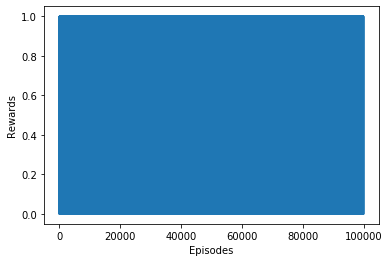

In [0]:
mcc.plot_graph()

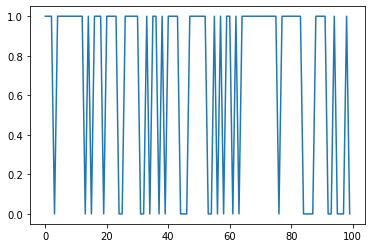

In [0]:
plt.plot(mcc.cum_rewards_data[-100:])
plt.show()

In [0]:
mcc.policy.render()

{0: 0, 1: 3, 2: 0, 3: 0, 4: 0, 6: 0, 8: 3, 9: 1, 10: 0, 13: 2, 14: 1}


In [0]:
mcc.simulate(wrap_env(gym.make(FROZEN_LAKE_ENV_NAME)))


SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
